# <a id='start'></a>  Germany post-processing long-term runs
In this Jupyter notebook, visualizations and analysis for a one year optimization are conducted (including dual dynamic programming (DDP) and stochastic dual dynamic programming (SDDP)

In this notebook the results of scenarios modelled with urbs are analysed and compared

* [Input](#input) 
* [Original urbs](#original)
    * [Validation and comparison](#original-validation)
    * [Visualization of intermitten supply duals](#original-supim)
    * [Visualization of marginal prices](#original-marginal)
    * [Visualization of dispatch](#original-dispatch)
    * [Visualization of residual load](#original-residual)
* [Mean urbs](#mean)
    * [Visualization of marginal prices](#mean-marginal)
    * [Visualization of dispatch](#mean-dispatch)
    * [Visualization of residual load](#mean-residual)
* [DDP urbs](#ddp)
* [SDDP urbs](#sddp)
    * [Comparison of storages](#comp)
    * [Comparison of dispatch](#dispatch)
* [Comparison of costs](#costs)


To run this notebook corretly, run the [Input](#input) part first!

***
***

## Input  <a id='input'></a> 
At first, needed packages are imported. Additionally, the input and global variables are defined.
(Back to [beginning](#start))

In [1]:
import os
import pandas as pd
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import re
from datetime import datetime

# map visualizations
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

# urbs package and self-written help scripts
import urbs
import define
import functions


%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define input
folder = 'h5'
folder_in = 'Input'
folder_out = 'Output'
subfolder = 'Visualization'
dt_h5 = '.h5'
dt_csv = '.csv'
dt_png = '.png'

h5_folder = 'h5_files'

datetime_origin = datetime(2015,1,1)

# some colors
tumblue = define.tumblue
tumblack = define.tumblack

# plot periods for dispatch
plot_periods = {'spring': ('2015-03-01', '2015-03-07'), 'summer': ('2015-06-01', '2015-06-07'),
                'autumn': ('2015-09-01', '2015-09-07'), 'winter': ('2015-12-01', '2015-12-07')}

plot_periods_num_mapper = {0: 'spring', 1: 'summer', 2: 'autumn', 3: 'winter'}

## Original urbs  <a id='original'></a> 
Analysis of original urbs
(Back to [beginning](#start))

In [3]:
folder = 'h5'
sub_folder_original = 'germany2015-20190326T1234-oneyear_base-lp-lp_exp'
scenarios_original = ['scenario_base', 'scenario_ls', 'scenario_ls_exp'] # options: base, ls, ls_exp
path_original = os.path.join(folder, sub_folder_original)
   
# extract result dictionary from result container
rc_original = {}
for scenario in scenarios_original:
    scenario_path = os.path.join(path_original, f"{scenario}{dt_h5}")
    rc_original[scenario] = urbs.load(scenario_path)

In [4]:
folder = 'h5'
sub_folder_original = 'germany2015-20190708T1226-oneyear_dispatch'
path_original = os.path.join(folder, sub_folder_original)

for scenario in ['scenario_ls_dis']:
    scenario_path = os.path.join(path_original, f"{scenario}{dt_h5}")
    rc_original[scenario] = urbs.load(scenario_path)

In [5]:
intermittent_duals = {}
supim_duals = {}
marginal_prices = {}

for scenario in scenarios_original:
    # save intermittent supply dual variables
    intermittent_duals_help = rc_original[scenario]._result['def_intermittent_supply'].copy(deep=True)
    # drop com from index
    intermittent_duals_help.index = intermittent_duals_help.index.droplevel('com')
    intermittent_duals[scenario] = intermittent_duals_help.unstack()

    # multiply by capacity to get dependency on supim time series
    help_df = rc_original[scenario]._result['cap_pro'].unstack()*intermittent_duals[scenario]
    supim_duals[scenario] = help_df.dropna(axis=1, how='all')
    
names = {
    'Solar plant': 'Photovoltaics',
    'Wind plant': 'Wind turbine'
}

for scenario in scenarios_original:
    help_df = supim_duals[scenario].unstack()
    supim_duals[scenario] = functions.set_date_index(help_df, datetime_origin).stack()

    supim_duals[scenario].rename(columns=names, inplace=True)
    

for scenario in scenarios_original:
    help_df = rc_original[scenario]._result['res_vertex'].xs('Elec', level=2).xs('Demand', level=2).unstack()
    marginal_prices[scenario] = functions.set_date_index(help_df, datetime_origin)

In [6]:
# process and storage
e_pro_out_original = {}
e_sto_in_original = {}
e_sto_out_original = {}

for scenario in scenarios_original:
    # process
    help_df = rc_original[scenario]._result['e_pro_out'].xs('Elec', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_pro_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)
    
    # storage in
    help_df = rc_original[scenario]._result['e_sto_in'].xs('Elec',
                                                       level='com').xs('Pumped storage',
                                                                       level='sto').unstack()
    e_sto_in_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    # storage out
    help_df = rc_original[scenario]._result['e_sto_out'].xs('Elec',
                                                        level='com').xs('Pumped storage',
                                                                        level='sto').unstack()
    e_sto_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)

In [7]:
# CO2
e_co2_out_original = {}

for scenario in scenarios_original:
    # process
    help_df = rc_original[scenario]._result['e_pro_out'].xs('CO2', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_co2_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)

In [8]:
# demand
demand_original = {}
demand_states_original = {}
for scenario in scenarios_original:
    # summed up demand
    help_df = rc_original[scenario]._data['demand'].xs('Elec', axis=1, level=1).sum(axis=1)
    demand_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    # demand per state
    help_df = rc_original[scenario]._data['demand'].xs('Elec', axis=1, level=1)
    demand_states_original[scenario] = functions.set_date_index(help_df, datetime_origin)

In [9]:
# storage capacity
cap_sto_c_original = {}
cap_sto_p_original = {}
for scenario in scenarios_original:
    cap_sto_c_original[scenario] = rc_original[scenario]._result['cap_sto_c'].xs('Elec',
                                                                         level=2).xs('Pumped storage', level=1)
    cap_sto_p_original[scenario] = rc_original[scenario]._result['cap_sto_p'].xs('Elec',
                                                                         level=2).xs('Pumped storage', level=1)

In [10]:
# new storage capacity
cap_sto_c_new_original = {}
cap_sto_p_new_original = {}
for scenario in scenarios_original:
    cap_sto_c_new_original[scenario] = rc_original[scenario]._result['cap_sto_c_new'].xs('Elec',
                                                                         level=2).xs('Pumped storage', level=1)
    cap_sto_p_new_original[scenario] = rc_original[scenario]._result['cap_sto_p_new'].xs('Elec',
                                                                         level=2).xs('Pumped storage', level=1)

### Validation and comparison <a id='original-validation'></a> 
Validation and comparison with statistics
(Back to [beginning](#start))

In [11]:
subfolder_lak = 'Timeseries'

# Define input paths for LAK
lak_paths = {'conv': os.path.join(folder_in, subfolder_lak, 'Bruttostromerzeugung 2015 konventionell'+dt_csv),
             'renew': os.path.join(folder_in, subfolder_lak, 'Bruttostromerzeugung 2015 erneuerbar'+dt_csv),
             'CO2': os.path.join(folder_in, subfolder, 'lak-co2-2014'+dt_csv)}

# Define results to compare
scenarios = {'urbs': 'scenario_base',
            }

# Importing color codes
cmap = [define.tumgreen, define.tumivory, define.tumviolet,
        define.tumgrey, define.tumblue, define.tumbrown, define.tumred,
        define.tumblack, define.tumbrightyellow, define.tumorange, 
        define.tumturquois, define.tumlightblue]

cmap_de = [define.tumbrown, define.tumgrey, define.tumred, define.tumivory, define.tumblack, define.tumturquois,
           define.tumgreen, define.tumlightblue, define.tumorange, define.tumblue,
           define.tumviolet, define.tumbrightyellow, define.tumgrey]

tumdarkblue = define.tumdarkblue
tumblue = define.tumblue
tumwhite = define.tumwhite

# Importing dict to translate state names to English
translation = define.states_translation_de_en

# Importing dict to translate fuel names
translation_fuel = define.fuel_translation_de_en

Read in data from [Länderarbeitskreis Energiebilanzen](http://www.lak-energiebilanzen.de/)
Here, the comparison data from LAK is read in.

In [12]:
# Read in conventional production in Germany in 2015
# Used columns for dem_load_states:
# 0: Bundesland - state
# 4-10: load for different production types per state
lak_conv = pd.read_csv(lak_paths['conv'], sep=';', na_values=['-', '.'], usecols=[0,4,5,6,7,8,10], 
                   index_col=0, skiprows=2, skipfooter=11, engine='python', encoding='latin1')
lak_conv.fillna(0, inplace=True)

# Read in renewable production in Germany in 2014 
# Used columns for dem_load_states:
# 0: Bundesland - state
# 4-8: load for different production types per state
lak_renew = pd.read_csv(lak_paths['renew'], sep=';', na_values=['-', '.'], usecols=[0,4,5,6,7,8], 
                    index_col=0, skiprows=2, skipfooter=7, engine='python', encoding='latin1')
lak_renew.fillna(0, inplace=True)

# Create dataframe for total production
lak_prod = pd.concat([lak_conv, lak_renew], axis=1)

# Translate states and fuel types to English
lak_prod = lak_prod.rename(index=translation)
lak_prod = lak_prod.rename(columns=translation_fuel)

# Sort dataframe
lak_prod = lak_prod.sort_index()
lak_prod = lak_prod.sort_index(axis=1)
lak_prod.head(5)

Biomass plant  Gas plant  Geothermal plant  \
Baden-Württemberg           4760       3436             198.0   
Bavaria                     8704       9211             390.0   
Berlin                       273       2541               0.0   
Brandenburg                 3617       2214             149.0   
Bremen                       422        228              33.0   

                   Hard coal plant  Hydro plant  Lignite plant  Nuclear plant  \
Baden-Württemberg          19407.0       4300.0            0.0        22517.0   
Bavaria                     4292.0      11206.0            0.0        36689.0   
Berlin                      3711.0          0.0          654.0            0.0   
Brandenburg                    0.0         18.0        33673.0            0.0   
Bremen                      4642.0         33.0            0.0            0.0   

                   Oil plant  Other plant  Solar plant  Wind plant  
Baden-Württemberg      272.0       2743.0         4863         831  
Bavaria                697.0       1244.0        11026        2784  
Berlin                  27.0        183.0           67          12  
Brandenburg             33.0       3374.0         2905        9476  
Bremen                  23.0       1614.0           30         340

CO$_2$ data is taken from ["energy data (Energiedaten)"](https://www.bmwi.de/Redaktion/DE/Artikel/Energie/energiedaten-gesamtausgabe.html)

In [13]:
#Define data for co2, values taken from BMWi, unit is Mt
co2_bwe = {'Lignite plant': 157.5,
           'Hard coal plant': 91.8,
           'Gas plant': 21.9,
           'Oil plant': 5.0,
           'Waste plant': 9.5,
           'Other plant': 19.6
          }

co2_bwe = pd.DataFrame(list(co2_bwe.items()))
co2_bwe.set_index(0, inplace=True)

In [14]:
# prepare validation dataframe
help_elec_ger=e_pro_out_original['scenario_base'].stack().sum(axis=0, level=1).sum()
help_co2_ger=e_co2_out_original['scenario_base'].stack().sum(axis=0, level=1).sum()

help_elec_ger['Other plant'] = help_elec_ger['Waste plant'] + help_elec_ger['Other plant']

help_elec_ger.drop('Waste plant', inplace=True)

In [15]:
# Add data for elec
urbs_elec_val = pd.concat([lak_prod.sum()/1000, help_elec_ger/1000000], axis=1)
urbs_elec_val.rename(columns={0: 'Statistics', 1: 'urbs'}, inplace=True)

#Add data for co2
urbs_co2_val = pd.concat([co2_bwe, help_co2_ger/1000000], axis=1)
urbs_co2_val.fillna(0, inplace=True)
urbs_co2_val.columns = ['BMWi','urbs',]

# Adapt dataframes to comparison files
urbs_elec_val.sort_index(inplace=True)
urbs_co2_val.sort_index(inplace=True)
    

# order
rows = ['Lignite', 'Hard coal', 'Nuclear', 'Gas',   
        'Oil', 'Other', 'Biomass', 'Wind', 'Solar', 'Hydro', 'Geothermal']

urbs_elec_val.rename(index=define.translate_fuel,inplace=True)
urbs_elec_val = urbs_elec_val.loc[rows, :]
urbs_co2_val.rename(index=define.translate_fuel,inplace=True)
urbs_co2_val = urbs_co2_val.loc[rows, :]

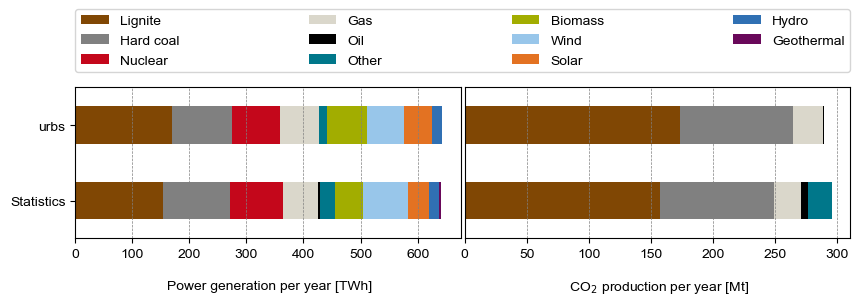

In [16]:
# Set hatch color
plt.rcParams['hatch.color'] = 'black'

# Plot validation in one figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,2), dpi=100)
fig.subplots_adjust(wspace = 0.01) # set space between subplots

# Plot elec
ax1 = urbs_elec_val.T.plot(kind='barh', stacked=True, legend=False, rot=0, color=cmap_de,
                           ax=axes[0])

# Add legend
#ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))#, prop={'size': })
ax1.set_xlabel('\n Power generation per year [TWh]')
ax1.xaxis.grid(color='grey', linestyle='--', linewidth=.5)

# Plot co2
ax2 = urbs_co2_val.T.plot(kind='barh', stacked=True, legend=False, rot=0, color=cmap_de,
                          ax=axes[1])


# Add legend
#ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))#, prop={'size': })
ax2.set_xlabel('\n CO$_2$ production per year [Mt]')
ax2.axes.get_yaxis().set_visible(False)
ax2.grid(color='grey', linestyle='--', linewidth=.5)

functions.legend_above(axes[0], anchorbox=(0., 1.1, 2.01, .102))

# Define output and save file
val_file_out = 'application-validation-ger'
val_path_out = os.path.join(folder_out, subfolder, val_file_out+dt_png)
plt.gcf().savefig(val_path_out, bbox_inches='tight', dpi=600)

### Visualization of intermittent supply duals  <a id='original-supim'></a> 
PV, Wind and hydro duals per time step
(Back to [beginning](#start))

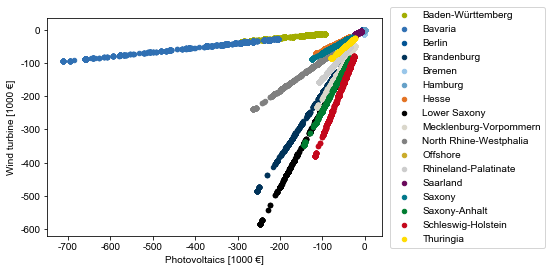

In [17]:
# plot of relation between PV and wind turbine duals

ax = plt.gca()

for sit in supim_duals['scenario_base'].index.get_level_values(1).unique():
    (supim_duals[scenario].xs(sit, level=1)/1000).plot.scatter(x='Photovoltaics', y='Wind turbine',
                                                        ax=ax, color=define.color_states[sit], label=sit)
    
functions.axis_thousand_comma(ax, ['x', 'y'])

ax.set_ylabel('Wind turbine [1000 €]')
ax.set_xlabel('Photovoltaics [1000 €]')

functions.legend_right(ax)

plt.savefig(os.path.join(folder_out, subfolder,'application-wind-pv-scatter.png'),
             bbox_inches='tight', dpi=600)

<Figure size 432x288 with 0 Axes>

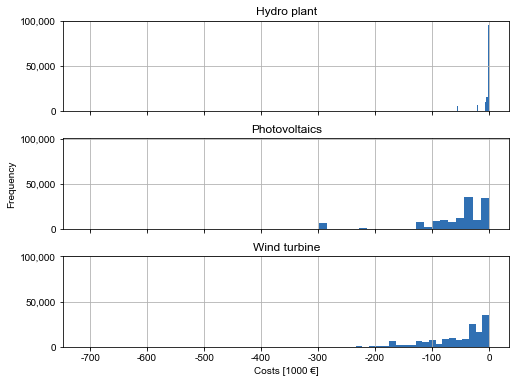

In [18]:
# plot of frequency of dual variables of pv, hydro and wind

fig = plt.figure()
# plot
axes = (supim_duals['scenario_base']/1000).hist(bins=50, sharey=True,
                                       sharex=True,layout=(3,1),
                                       figsize=(8,6), color=tumblue)

for ax in axes:
    functions.axis_thousand_comma(ax[0], ['x', 'y'])

axes[1][0].set_ylabel('Frequency')
axes[2][0].set_xlabel('Costs [1000 €]')

plt.savefig(os.path.join(folder_out, subfolder, 'application-supim-duals.png'), dpi=600)

<Figure size 432x288 with 0 Axes>

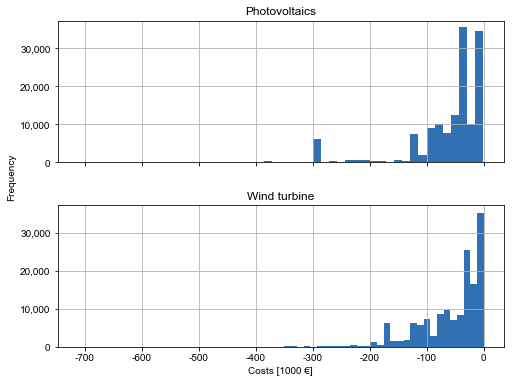

In [19]:
# plot of frequency of dual variables of pv and wind

fig = plt.figure()
# plot
axes = (supim_duals['scenario_base'].drop('Hydro plant', axis=1)/1000).hist(bins=50, sharey=True,
                                                                   sharex=True,layout=(2,1),
                                                                   figsize=(8,6), color=tumblue)

for ax in axes:
    functions.axis_thousand_comma(ax[0], ['x', 'y'])

axes[1][0].set_ylabel('Frequency', position=(0,1.2))
axes[1][0].set_xlabel('Costs [1000 €]')

plt.savefig(os.path.join(folder_out, subfolder, 'application-pv-wind-duals.png'), dpi=600)

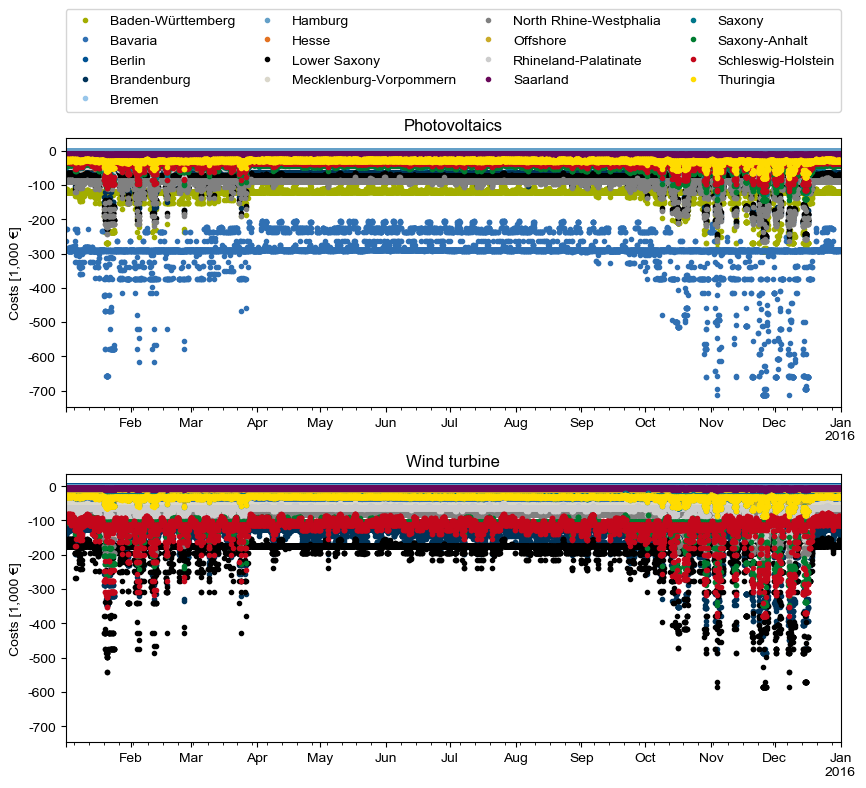

In [20]:
# plot of dual variables per state of pv and wind

fig, ax = plt.subplots(nrows = 2, ncols=1, figsize=(10,8), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

for sit in supim_duals['scenario_base'].index.get_level_values(1).unique():
    (supim_duals['scenario_base'].Photovoltaics.xs(sit, level=1)/1000).plot(marker='.', linestyle='', ax=ax[0],
                                                               color=define.color_states[sit],
                                                               label=sit)
    
    
for sit in supim_duals['scenario_base'].index.get_level_values(1).unique():
    (supim_duals['scenario_base']['Wind turbine'].xs(sit, level=1)/1000).plot(marker='.', linestyle='',
                                                                 ax=ax[1], color=define.color_states[sit],
                                                                 label=sit)
    
    
    functions.axis_thousand_comma(ax[0], ['y'])
    functions.axis_thousand_comma(ax[1], ['y'])

    ax[0].set_title(f'Photovoltaics')
    ax[1].set_title(f'Wind turbine')
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Costs [1,000 €]')
    ax[1].set_xlabel('')
    ax[1].set_ylabel('Costs [1,000 €]')


functions.legend_above(ax[0], anchorbox=(0., 1.1, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder, f'application-pv-wind-duals-year.png'),
            bbox_inches='tight', dpi=600)

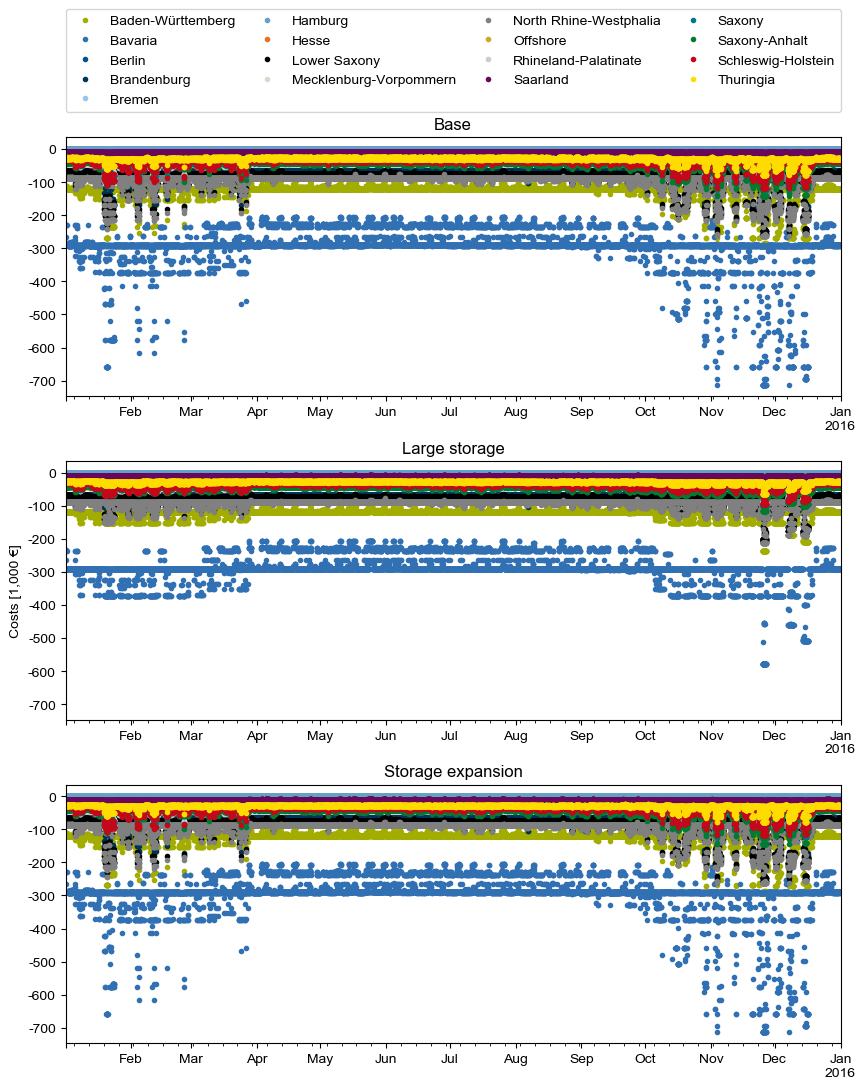

In [21]:
# dual variables per scenario and state for pv
fig, ax = plt.subplots(nrows = len(scenarios_original), ncols=1, figsize=(10,12), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

for scen in range(0, len(scenarios_original)):
    for sit in supim_duals[scenarios_original[scen]].index.get_level_values(1).unique():
        plot_element = supim_duals[scenarios_original[scen]].Photovoltaics.xs(sit,level=1)
        (plot_element/1000).plot(marker='.', linestyle='', ax=ax[scen],
                                 color=define.color_states[sit], label=sit)
    
    functions.axis_thousand_comma(ax[scen], ['y'])

    ax[scen].set_title(f'{define.scenario_names[scenarios_original[scen]]}')
    ax[scen].set_xlabel('')


functions.legend_above(ax[0], anchorbox=(0., 1.1, 1., .102))
ax[np.floor(len(scenarios_original)/2).astype('int')].set_ylabel('Costs [1,000 €]')

plt.savefig(os.path.join(folder_out, subfolder, f'application-cs-pv-duals.png'),
            bbox_inches='tight', dpi=600)

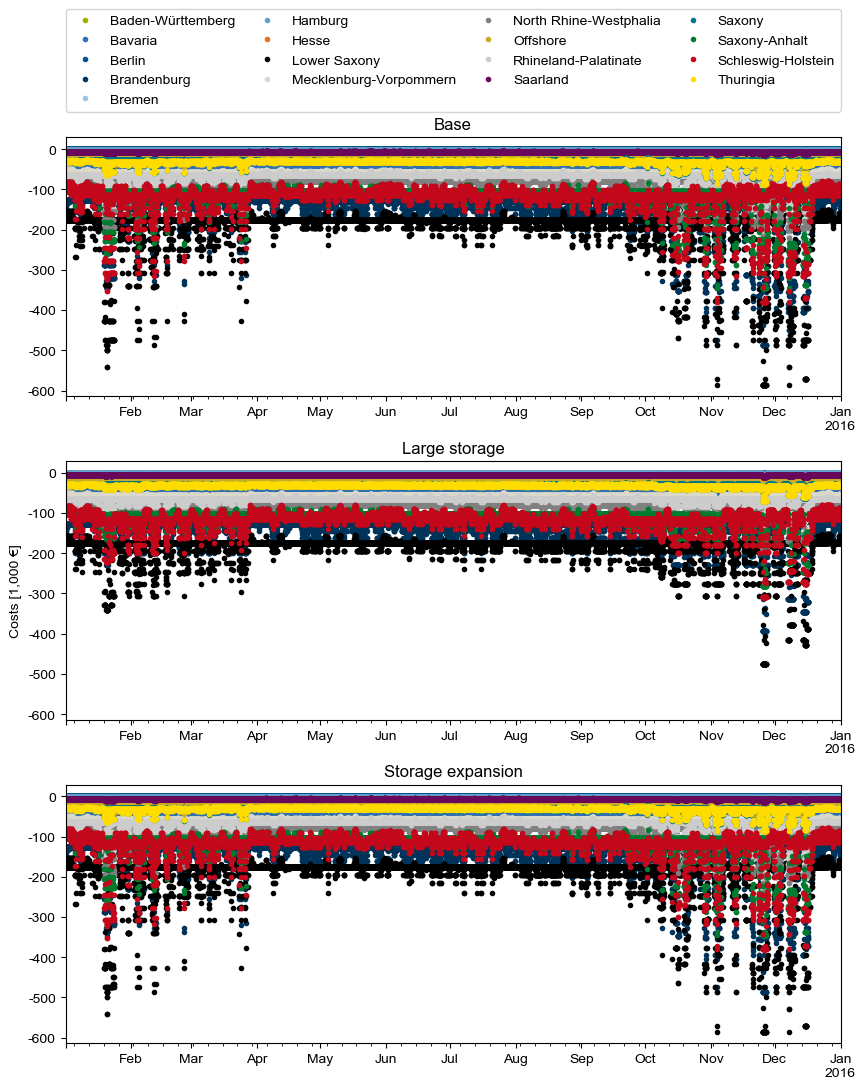

In [22]:
# dual variables per scenario and state for wind
fig, ax = plt.subplots(nrows = len(scenarios_original), ncols=1, figsize=(10,12), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

for scen in range(0, len(scenarios_original)):
    for sit in supim_duals[scenarios_original[scen]].index.get_level_values(1).unique():
        plot_element = supim_duals[scenarios_original[scen]]['Wind turbine'].xs(sit, level=1)
        (plot_element/1000).plot(marker='.', linestyle='', ax=ax[scen],
                                 color=define.color_states[sit], label=sit)
    
    functions.axis_thousand_comma(ax[scen], ['y'])

    ax[scen].set_title(f'{define.scenario_names[scenarios_original[scen]]}')
    ax[scen].set_xlabel('')


functions.legend_above(ax[0], anchorbox=(0., 1.1, 1., .102))
ax[np.floor(len(scenarios_original)/2).astype('int')].set_ylabel('Costs [1,000 €]')

plt.savefig(os.path.join(folder_out, subfolder, f'application-cs-wind-duals.png'),
            bbox_inches='tight', dpi=600)

### Visualization of marginal prices  <a id='original-marginal'></a> 
Marginal prices
(Back to [beginning](#start))

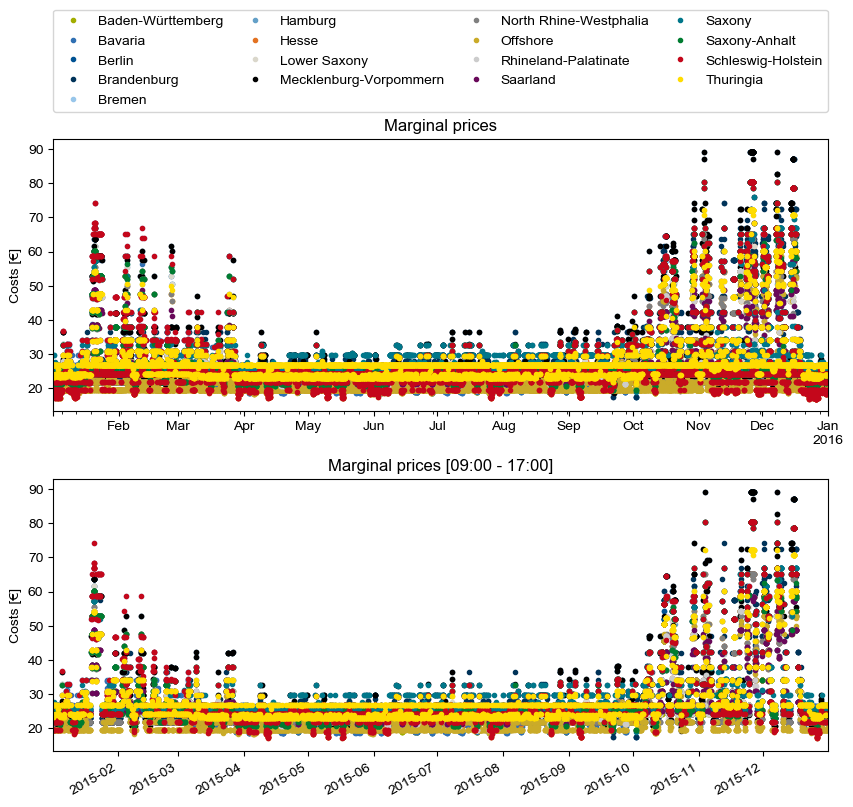

In [23]:
# marginal prices for the whole year per state and during suntime
fig, ax = plt.subplots(nrows = 2, ncols=1, figsize=(10,9), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

marginal_prices['scenario_base'].plot(marker='.', linestyle='', ax=ax[0],
                             color=define.color_states.values(), legend=False)

marginal_prices['scenario_base'].between_time('9:00','17:00').plot(marker='.', linestyle='', ax=ax[1],
                                                          color=define.color_states.values(),
                                                          legend=False)
    

ax[0].set_title(f'Marginal prices')
ax[0].set_xlabel('')
ax[0].set_ylabel('Costs [€]')

ax[1].set_title(f'Marginal prices [09:00 - 17:00]')
ax[1].set_xlabel('')
ax[1].set_ylabel('Costs [€]')


functions.legend_above(ax[0], anchorbox=(0., 1.1, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder,'application-marginal-prices.png'),
             bbox_inches='tight', dpi=600)

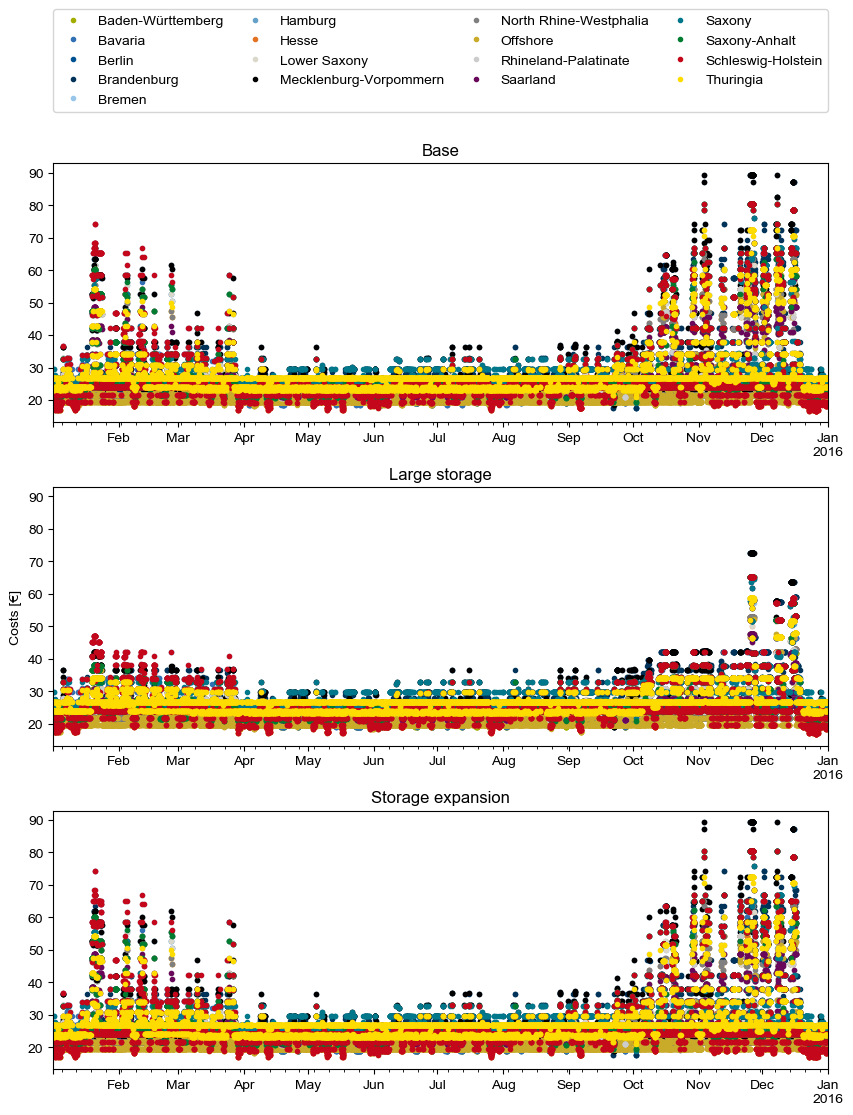

In [24]:
# marginal prices per scenario and time
fig, ax = plt.subplots(nrows = len(scenarios_original), ncols=1, figsize=(10,12), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

for scen in range(0, len(scenarios_original)):
    marginal_prices[scenarios_original[scen]].plot(marker='.', linestyle='', ax=ax[scen],
                                                   color=define.color_states.values(),
                                                   legend=False)
    
    functions.axis_thousand_comma(ax[scen], ['y'])

    ax[scen].set_title(f'{define.scenario_names[scenarios_original[scen]]}')
    ax[scen].set_xlabel('')


functions.legend_above(ax[0], anchorbox=(0., 1.2, 1., .102))
ax[np.floor(len(scenarios_original)/2).astype('int')].set_ylabel('Costs [€]')


plt.savefig(os.path.join(folder_out, subfolder, f'application-cs-marginal_prices.png'),
            bbox_inches='tight', dpi=600)

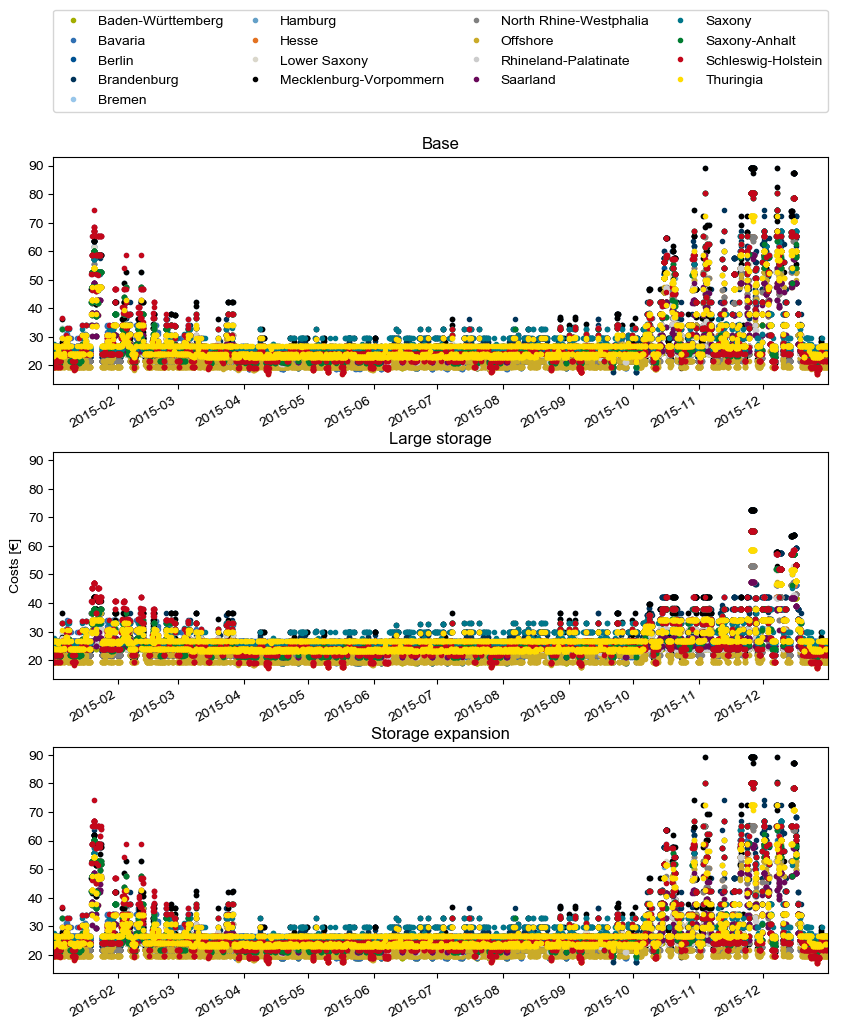

In [25]:
# marginal prices per scenario and time during daytime
fig, ax = plt.subplots(nrows = len(scenarios_original), ncols=1, figsize=(10,12), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.3) 

for scen in range(0, len(scenarios_original)):
    plot_element = marginal_prices[scenarios_original[scen]].between_time('9:00','17:00')
    plot_element.plot(marker='.', linestyle='', ax=ax[scen],
                      color=define.color_states.values(), legend=False)
    
    functions.axis_thousand_comma(ax[scen], ['y'])

    ax[scen].set_title(f'{define.scenario_names[scenarios_original[scen]]}')
    ax[scen].set_xlabel('')


functions.legend_above(ax[0], anchorbox=(0., 1.2, 1., .102))
ax[np.floor(len(scenarios_original)/2).astype('int')].set_ylabel('Costs [€]')


plt.savefig(os.path.join(folder_out, subfolder, f'application-cs-marginal_prices-day.png'),
            bbox_inches='tight', dpi=600)

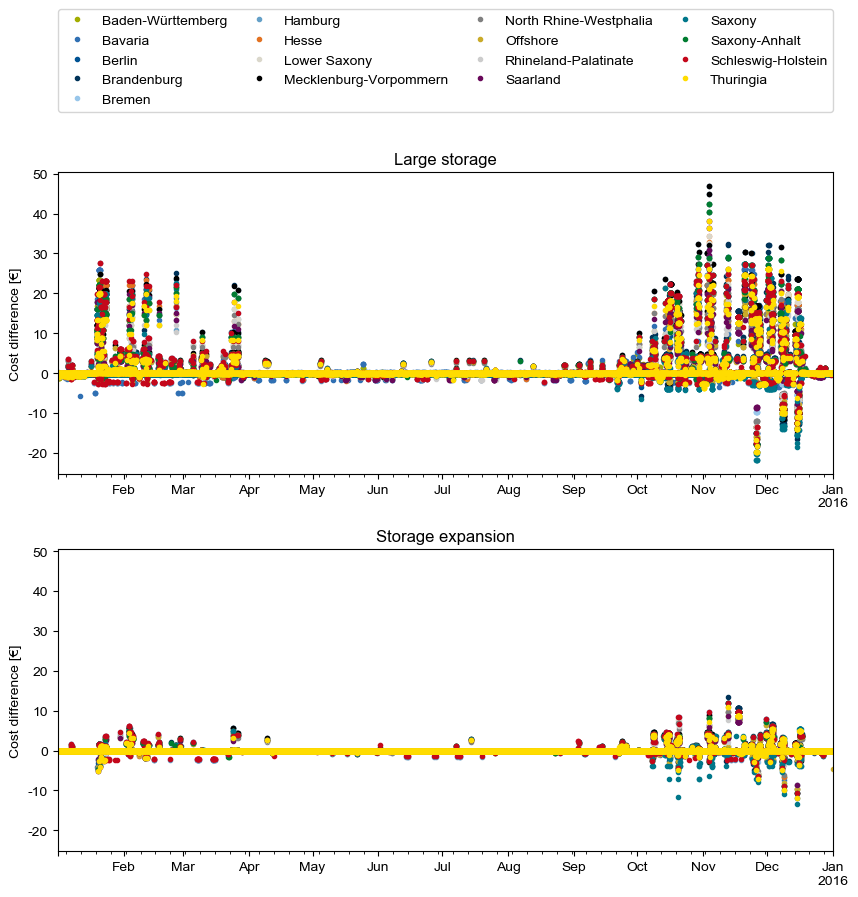

In [26]:
# plot of differences via scenarios_original in marginal prices
fig, ax = plt.subplots(nrows = len(scenarios_original)-1, ncols=1, figsize=(10,9), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

for scen in range(1, len(scenarios_original)):
    diff = (marginal_prices['scenario_base'] - marginal_prices[scenarios_original[scen]])
    diff.plot(marker='.', linestyle='', ax=ax[scen-1], color=define.color_states.values(), legend=False)
    
    functions.axis_thousand_comma(ax[scen-1], ['y'])

    ax[scen-1].set_title(f'{define.scenario_names[scenarios_original[scen]]}')
    ax[scen-1].set_xlabel('')
    ax[scen-1].set_ylabel('Cost difference [€]')

functions.legend_above(ax[0], anchorbox=(0., 1.2, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder, 'application-marginal-prices-diff.png'),
            bbox_inches='tight', dpi=600)

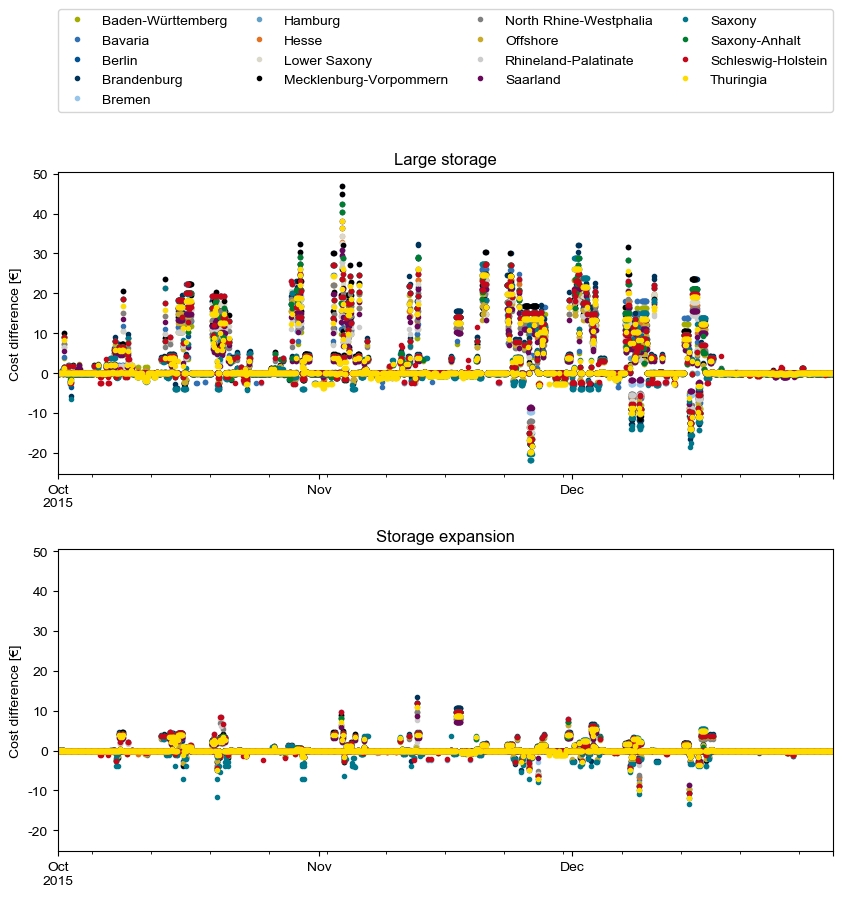

In [83]:
# plot of differences via scenarios_original in marginal prices
fig, ax = plt.subplots(nrows = len(scenarios_original)-1, ncols=1, figsize=(10,9), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

for scen in range(1, len(scenarios_original)):
    diff = (marginal_prices['scenario_base']['2015-10':'2015-12'] - marginal_prices[scenarios_original[scen]]['2015-10':'2015-12'])
    diff.plot(marker='.', linestyle='', ax=ax[scen-1], color=define.color_states.values(), legend=False)
    
    functions.axis_thousand_comma(ax[scen-1], ['y'])

    ax[scen-1].set_title(f'{define.scenario_names[scenarios_original[scen]]}')
    ax[scen-1].set_xlabel('')
    ax[scen-1].set_ylabel('Cost difference [€]')

functions.legend_above(ax[0], anchorbox=(0., 1.2, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder, 'application-marginal-prices-diff-winter.png'),
            bbox_inches='tight', dpi=600)

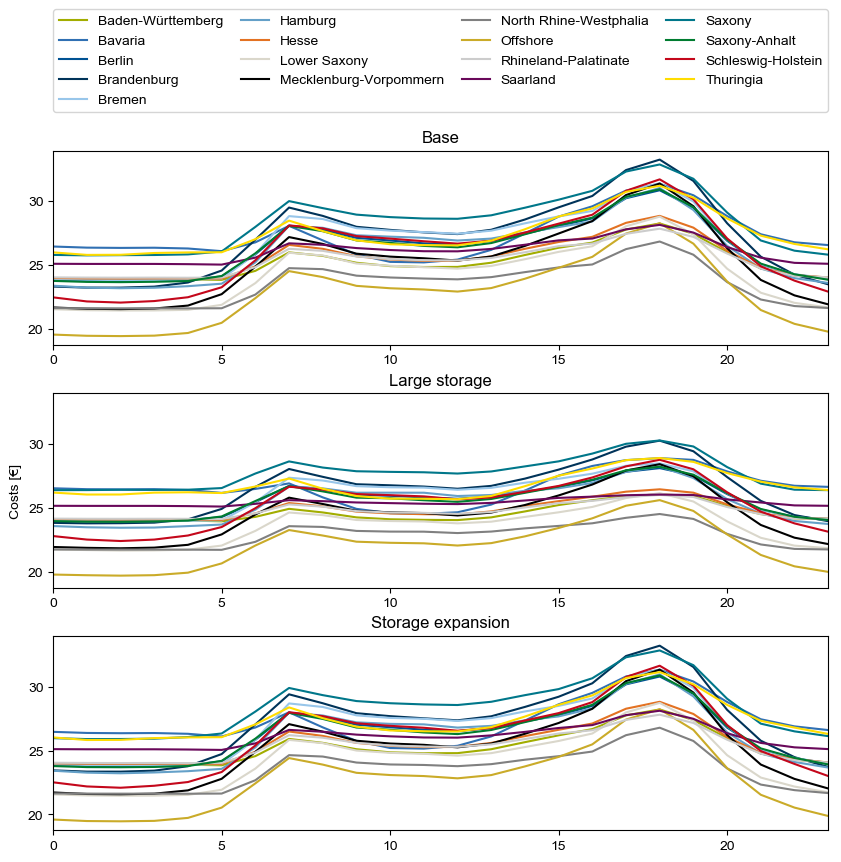

In [27]:
# plot mean marginal prices per hour
fig, ax = plt.subplots(nrows = len(scenarios_original), ncols=1,
                       figsize=(10,9), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

for scen in range(0, len(scenarios_original)):
    plot_element = marginal_prices[scenarios_original[scen]]
    plot_element = plot_element.groupby(plot_element.index.hour).mean()
    plot_element.plot(ax=ax[scen], color=define.color_states.values(), legend=False)

    ax[scen].set_xlabel('')

    ax[scen].set_title(f'{define.scenario_names[scenarios_original[scen]]}')
    
        
functions.legend_above(ax[0], anchorbox=(0., 1.2, 1., .102))
ax[np.floor(len(scenarios_original)/2).astype('int')].set_ylabel('Costs [€]')

plt.savefig(os.path.join(folder_out, subfolder,'application-marginal-prices-mean-per-hour.png'),
            bbox_inches='tight', dpi=600)

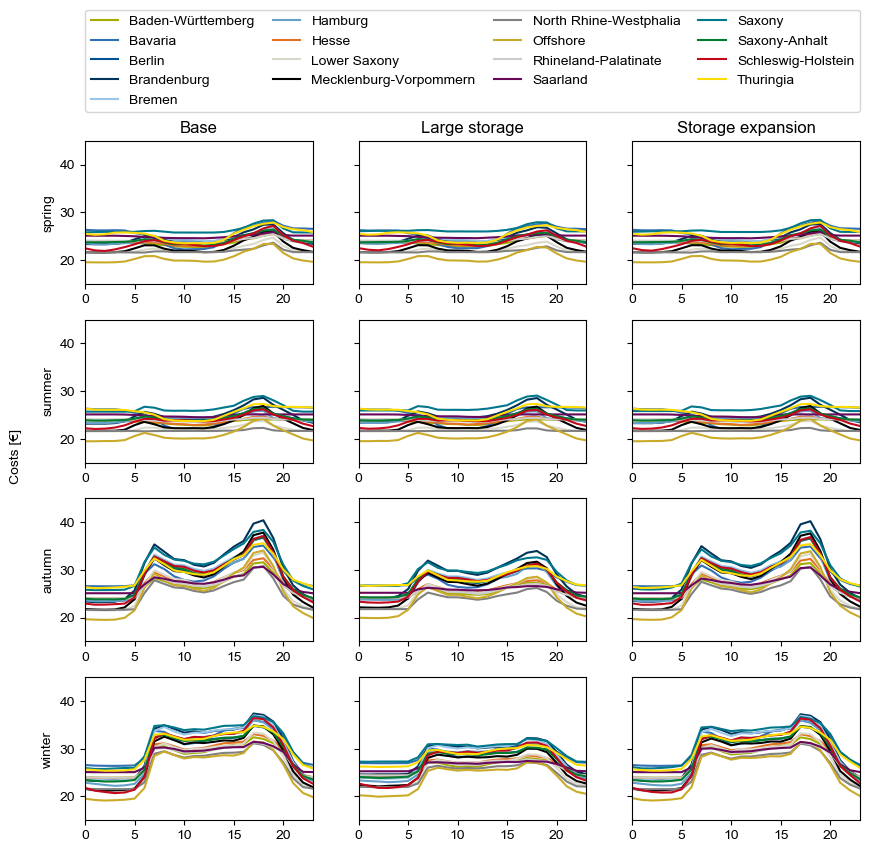

In [28]:
# plot mean marginal prices per hour and season
seasons = ['spring', 'summer', 'autumn', 'winter']
fig, ax = plt.subplots(ncols = len(scenarios_original), nrows=len(seasons),
                       figsize=(10,9), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

for sean in range(0,len(seasons)):
    for scen in range(0, len(scenarios_original)):
        plot_element = functions.extract_season(marginal_prices[scenarios_original[scen]], seasons[sean])
        plot_element = plot_element.groupby(plot_element.index.hour).mean()
        plot_element.plot(ax=ax[sean,scen], color=define.color_states.values(), legend=False)

        ax[sean,scen].set_xlabel('')
        ax[sean,scen].set_ylim([15,45])
    
        ax[0,scen].set_title(f'{define.scenario_names[scenarios_original[scen]]}')
        ax[sean,0].set_ylabel(f'{seasons[sean]}')
        
functions.legend_above(ax[0,0], anchorbox=(0., 1.2, 3.4, .102))
fig.text(0.05, 0.55, 'Costs [€]', rotation=90)
    

plt.savefig(os.path.join(folder_out, subfolder,'application-marginal-prices-mean-per-season.png'),
            bbox_inches='tight', dpi=600)

### Visualization of dispatch  <a id='original-dispatch'></a> 
Visualization for dispatch in urbs original
(Back to [beginning](#start))

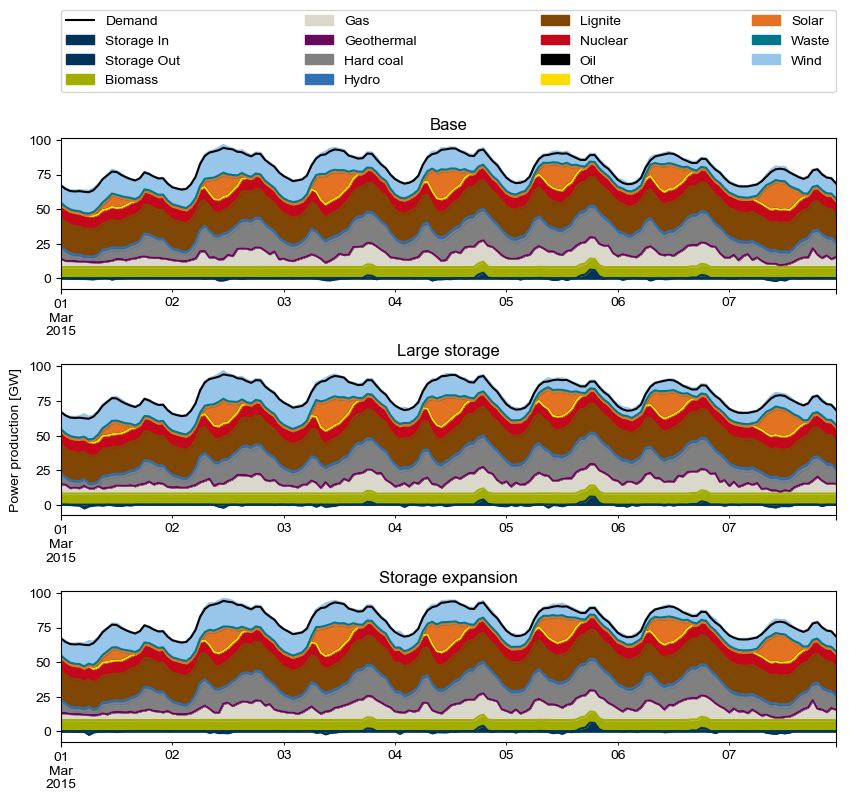

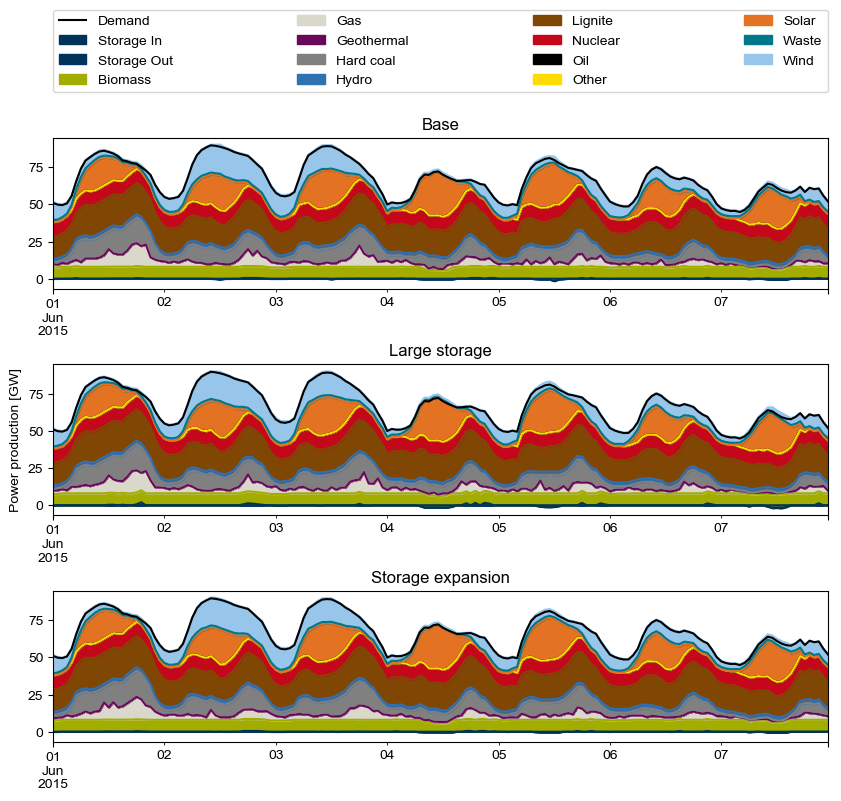

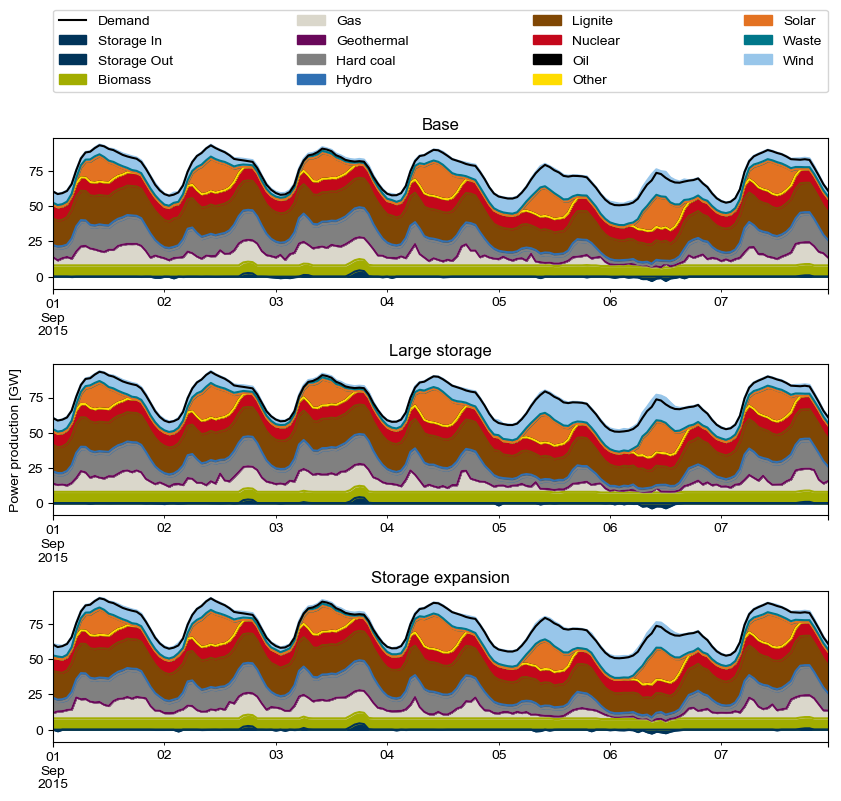

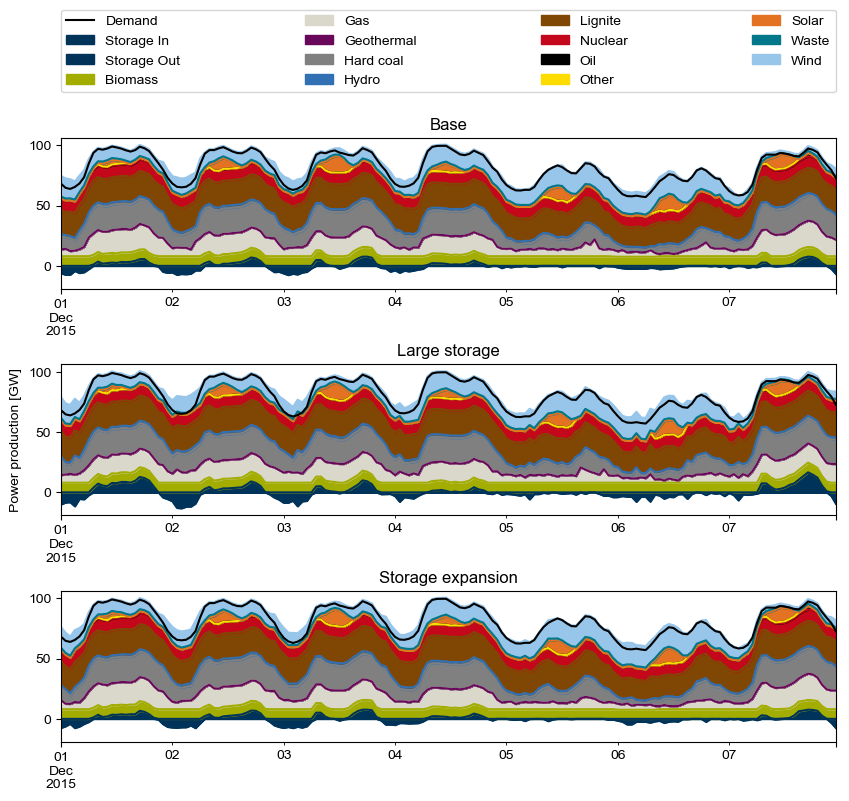

In [29]:
# dispatch per scenario
for period in plot_periods:
    fig, ax = plt.subplots(nrows = len(scenarios_original), figsize=(10,8), dpi=100, sharey=True)

    # Set space between subplots
    fig.subplots_adjust(hspace = 0.5) 

    for scen in range(0, len(scenarios_original)):
        e_pro = e_pro_out_original[scenarios_original[scen]].sum(axis=1, level=0)
        e_pro.rename(columns=define.translate_fuel,inplace=True)
        sto_out = e_sto_out_original[scenarios_original[scen]].sum(axis=1)
        sto_out.rename('Storage Out', inplace=True)
        sto_in = -e_sto_in_original[scenarios_original[scen]].sum(axis=1)
        sto_in.rename('Storage In', inplace=True)
        plot_element = pd.concat([sto_in, sto_out, e_pro], axis=1)
        plot_element = plot_element[plot_periods[period][0]:plot_periods[period][1]]
        (plot_element/1000).plot(kind='area', stacked=True, ax=ax[scen],
                                 legend=False, color=define.color_fuels.values())
        
        # plot demand
        plot_element = demand_original[scenarios_original[scen]][plot_periods[period][0]:plot_periods[period][1]]
        plot_element.rename('Demand', inplace=True)
        (plot_element/1000).plot(ax=ax[scen], color=tumblack)
        
        functions.axis_thousand_comma(ax[scen], ['y'])
        ax[scen].set_xlabel('')
        ax[scen].set_title(f'{define.scenario_names[scenarios_original[scen]]}')

    ax[np.floor(len(scenarios_original)/2).astype('int')].set_ylabel('Power production [GW]')
    functions.legend_above(ax[0])
    
    plt.savefig(os.path.join(folder_out, subfolder, f'application-e_pro_out-{period}.png'),
                bbox_inches='tight', dpi=600)

### Visualization of residual load  <a id='original-residual'></a> 
Visualization for residual load in urbs original
(Back to [beginning](#start))

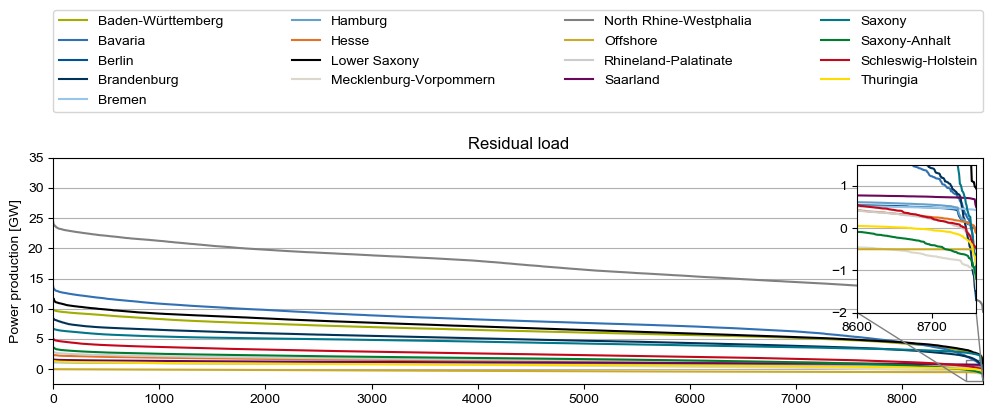

In [30]:
# residual load ordered
fig, ax = plt.subplots(nrows = 1, figsize=(12,3), dpi=100)


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
axins = zoomed_inset_axes(ax, 7, loc=1) # zoom-factor: 7, location: upper-right?

states = demand_states_original['scenario_base'].columns.sort_values()
res = ['Solar plant', 'Wind plant']


for state in states:
    res_pro = e_pro_out_original['scenario_base'].xs(res, axis=1).sum(axis=1, level=1).xs(state, axis=1)
    plot_element = demand_states_original['scenario_base'][state] - res_pro
    plot_element = plot_element.sort_values(ascending=False).reset_index()[state]
    plot_element.index += 1
    (plot_element/1000).plot(ax=ax, legend=False, color=define.color_states[state])
    (plot_element/1000).plot(ax=axins, legend=False, color=define.color_states[state])

    
x1, x2, y1, y2 = 8600, 8760, -2, 1.5# specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.yaxis.grid(True)
ax.set_xlabel('')
ax.set_title('Residual load')
ax.set_ylabel('Power production [GW]')
ax.set_ylim([-2.5,35])
ax.yaxis.grid(True)
functions.legend_above(ax, anchorbox=(0., 1.2, 1., .102))
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.5")


plt.savefig(os.path.join(folder_out, subfolder, 'application-residual-load-state.png'),
            bbox_inches='tight', dpi=600)

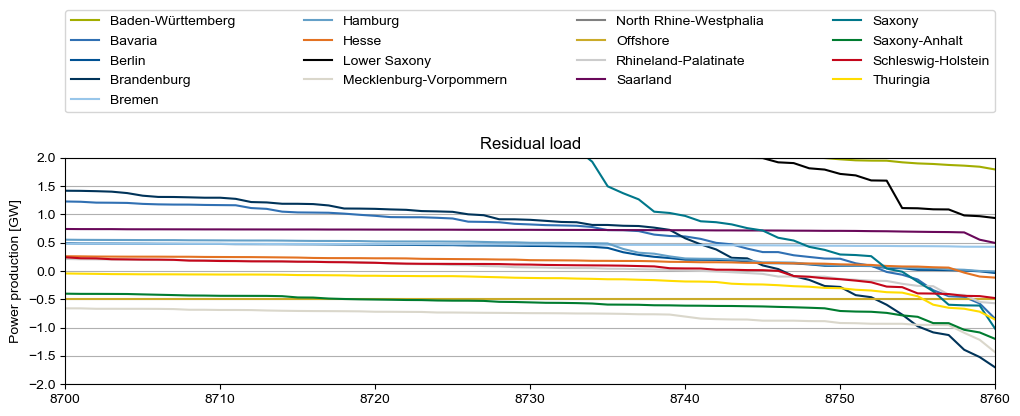

In [31]:
# zoomed in residual load for negative values

fig, ax = plt.subplots(nrows = 1, figsize=(12,3), dpi=100)

states = demand_states_original['scenario_base'].columns.sort_values()
#['Bremen', 'Hamburg','Mecklenburg-Vorpommern', 'Brandenburg', 'Schleswig-Holstein']
res = ['Solar plant', 'Wind plant']

# Set space between subplots
#fig.subplots_adjust(hspace = 0.5) 

for state in states:
    res_pro = e_pro_out_original['scenario_base'].xs(res, axis=1).sum(axis=1, level=1).xs(state, axis=1)
    plot_element = demand_states_original['scenario_base'][state] - res_pro
    plot_element = plot_element.sort_values(ascending=False).reset_index()[state]
    plot_element.index += 1
    (plot_element/1000).plot(ax=ax, legend=False, color=define.color_states[state])
    (plot_element/1000).plot(ax=axins, legend=False, color=define.color_states[state])
    

ax.set_xlabel('')
ax.set_title('Residual load')
ax.set_ylabel('Power production [GW]')
ax.set_xlim([8700, 8760])
ax.set_ylim([-2.0,2.0])
ax.yaxis.grid(True)
functions.legend_above(ax, anchorbox=(0., 1.2, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder, 'application-residual-load-state-end.png'),
            bbox_inches='tight', dpi=600)

## Mean urbs  <a id='mean'></a> 
Analysis of urbs with mean input time series for wind
(Back to [beginning](#start))

In [32]:
sub_folder_mean = 'germany2015mean-20190406T0759'
scenarios_mean = ['scenario_base', 'scenario_ls', 'scenario_ls_exp']
path_mean = os.path.join(folder, sub_folder_mean)

rc_mean = {}
for scenario in scenarios_mean:
    scenario_path = os.path.join(path_mean, f"{scenario}{dt_h5}")
    rc_mean[scenario] = urbs.load(scenario_path)

In [33]:
# process and storage
e_pro_out_mean = {}
e_sto_in_mean = {}
e_sto_out_mean = {}

for scenario in scenarios_mean:
    # process
    help_df = rc_mean[scenario]._result['e_pro_out'].xs('Elec', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_pro_out_mean[scenario] = functions.set_date_index(help_df, datetime_origin)
    
    # storage in
    help_df = rc_mean[scenario]._result['e_sto_in'].xs('Elec',
                                                       level='com').xs('Pumped storage',
                                                                       level='sto').unstack()
    e_sto_in_mean[scenario] = functions.set_date_index(help_df, datetime_origin)

    # storage out
    help_df = rc_mean[scenario]._result['e_sto_out'].xs('Elec',
                                                        level='com').xs('Pumped storage',
                                                                        level='sto').unstack()
    e_sto_out_mean[scenario] = functions.set_date_index(help_df, datetime_origin)

In [34]:
# demand
demand_mean = {}
demand_states_mean = {}
for scenario in scenarios_mean:
    # summed up demand
    help_df = rc_mean[scenario]._data['demand'].xs('Elec', axis=1, level=1).sum(axis=1)
    demand_mean[scenario] = functions.set_date_index(help_df, datetime_origin)

    # demand per state
    help_df = rc_mean[scenario]._data['demand'].xs('Elec', axis=1, level=1)
    demand_states_mean[scenario] = functions.set_date_index(help_df, datetime_origin)

In [35]:
# storage capacity
cap_sto_c_mean = {}
cap_sto_p_mean = {}
for scenario in scenarios_mean:
    cap_sto_c_mean[scenario] = rc_mean[scenario]._result['cap_sto_c'].xs('Elec',
                                                                         level=2).xs('Pumped storage', level=1)
    cap_sto_p_mean[scenario] = rc_mean[scenario]._result['cap_sto_p'].xs('Elec',
                                                                         level=2).xs('Pumped storage', level=1)

In [36]:
# storage capacity
cap_sto_c_new_mean = {}
cap_sto_p_new_mean = {}
for scenario in scenarios_mean:
    cap_sto_c_new_mean[scenario] = rc_mean[scenario]._result['cap_sto_c_new'].xs('Elec',
                                                                         level=2).xs('Pumped storage', level=1)
    cap_sto_p_new_mean[scenario] = rc_mean[scenario]._result['cap_sto_p_new'].xs('Elec',
                                                                         level=2).xs('Pumped storage', level=1)

### Visualization of marginal prices  <a id='mean-marginal'></a> 
Marginal prices for mean wind time series
(Back to [beginning](#start))

In [37]:
# marginal prices
marginal_prices_mean = {}

for scenario in scenarios_mean:
    help_df = rc_mean[scenario]._result['res_vertex'].xs('Elec', level=2).xs('Demand', level=2).unstack()
    marginal_prices_mean[scenario] = functions.set_date_index(help_df, datetime_origin)

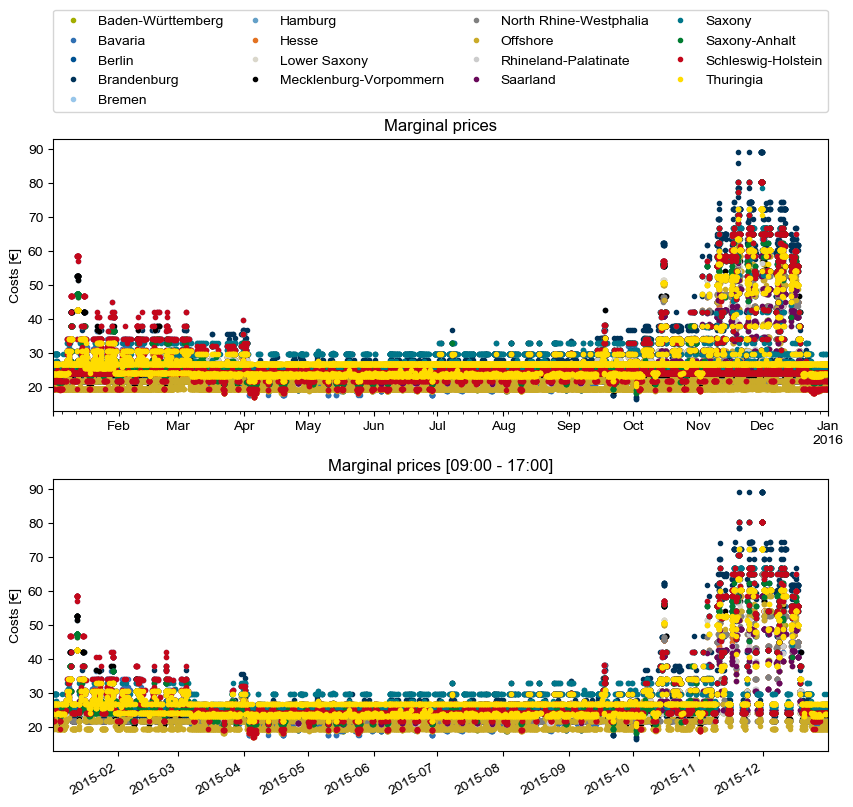

In [38]:
# marginal prices
fig, ax = plt.subplots(nrows = 2, ncols=1, figsize=(10,9), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

marginal_prices_mean['scenario_base'].plot(marker='.', linestyle='', ax=ax[0],
                                             color=define.color_states.values(), legend=False)

marginal_prices_mean['scenario_base'].between_time('9:00','17:00').plot(marker='.', linestyle='',
                                                                        ax=ax[1],
                                                                        color=define.color_states.values(),
                                                                        legend=False)
    

ax[0].set_title(f'Marginal prices')
ax[0].set_xlabel('')
ax[0].set_ylabel('Costs [€]')

ax[1].set_title(f'Marginal prices [09:00 - 17:00]')
ax[1].set_xlabel('')
ax[1].set_ylabel('Costs [€]')


ax[0].legend(bbox_to_anchor=(0., 1.1, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.)

plt.savefig(os.path.join(folder_out, subfolder, 'application-cs-marginal-prices-mean.png'),
            bbox_inches='tight', dpi=600)

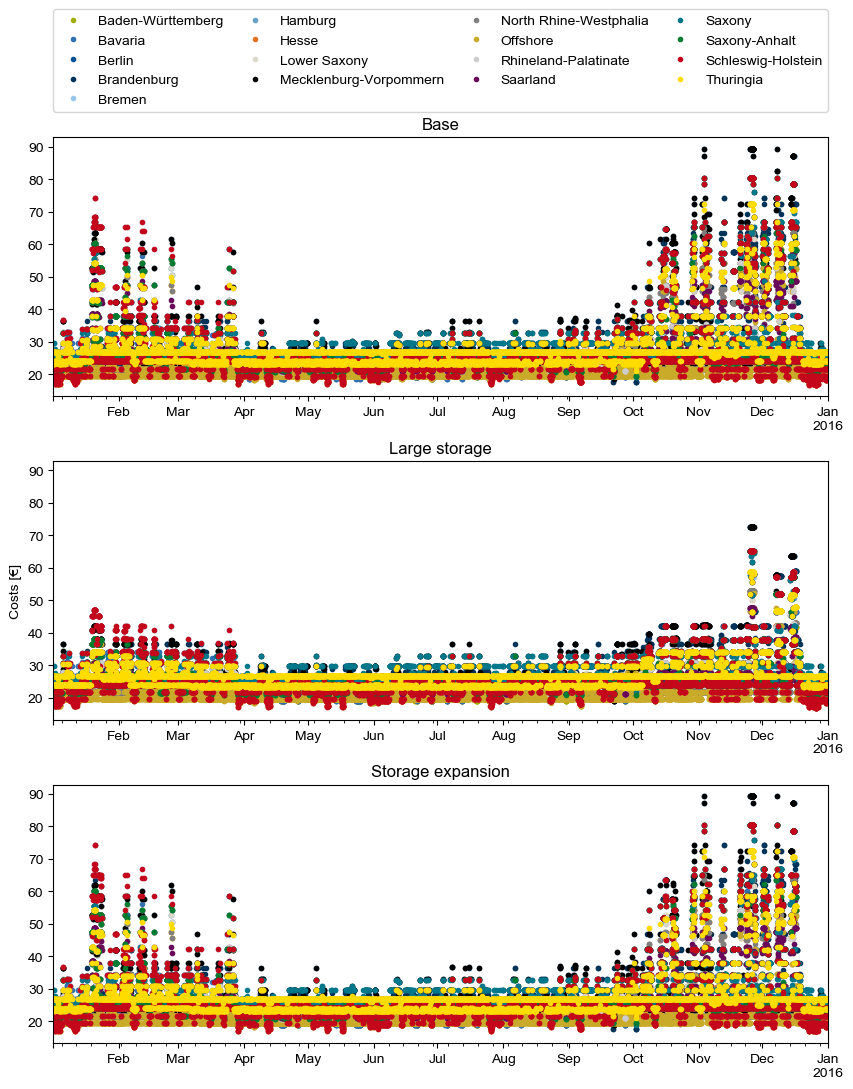

In [39]:
# marginal prices per scenario
fig, ax = plt.subplots(nrows = len(scenarios_mean), ncols=1, figsize=(10,12), dpi=100, sharey=True)

# Set space between subplots
fig.subplots_adjust(hspace = 0.25) 

for scen in range(0, len(scenarios_mean)):
    marginal_prices[scenarios_mean[scen]].plot(marker='.', linestyle='', ax=ax[scen],
                                               color=define.color_states.values(), legend=False)
    
    functions.axis_thousand_comma(ax[scen], ['y'])

    ax[scen].set_title(f'{define.scenario_names[scenarios_mean[scen]]}')
    ax[scen].set_xlabel('')


ax[0].legend(bbox_to_anchor=(0., 1.1, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.)
ax[np.floor(len(scenarios_mean)/2).astype('int')].set_ylabel('Costs [€]')

plt.savefig(os.path.join(folder_out, subfolder, 'application-cs-marginal-prices-mean.png'), 
            bbox_inches='tight', dpi=600)

### Visualization of dispatch  <a id='mean-dispatch'></a> 
Visualization for dispatch in urbs with mean wind time series
(Back to [beginning](#start))

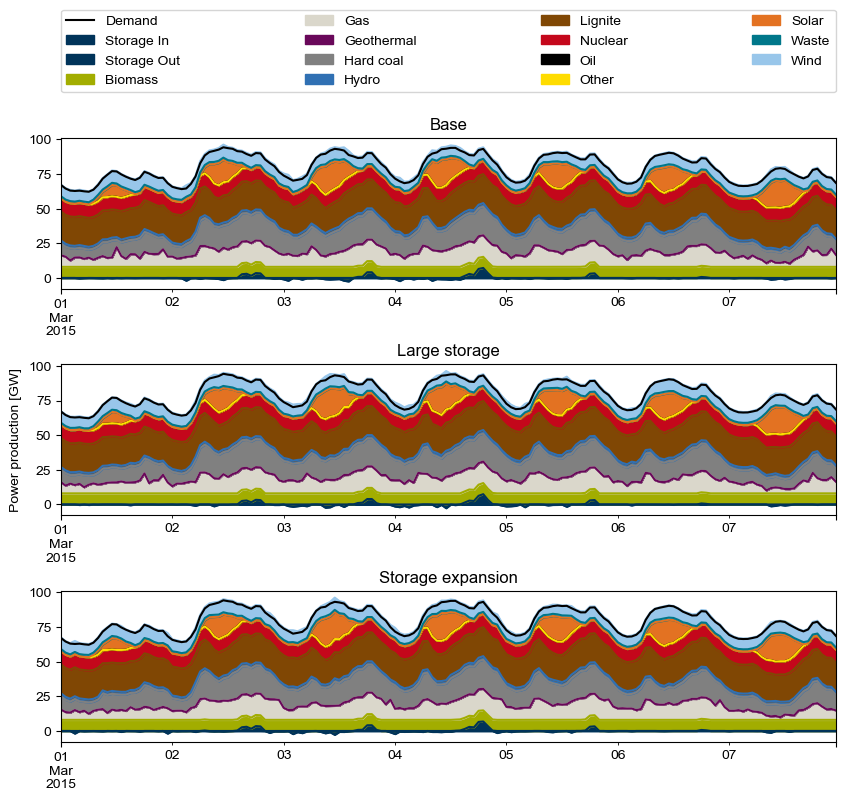

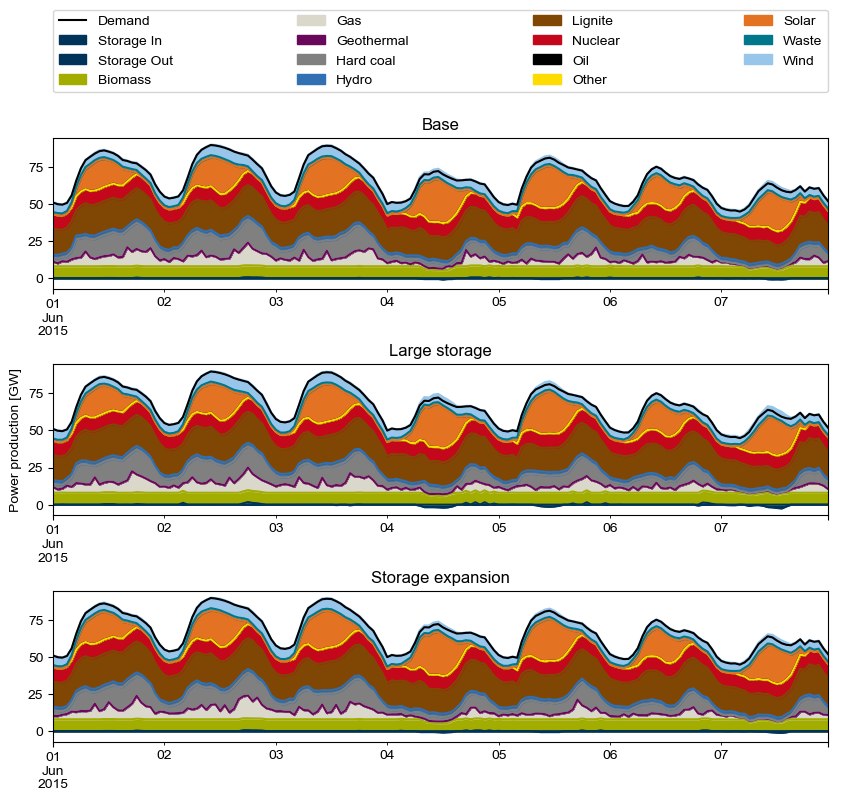

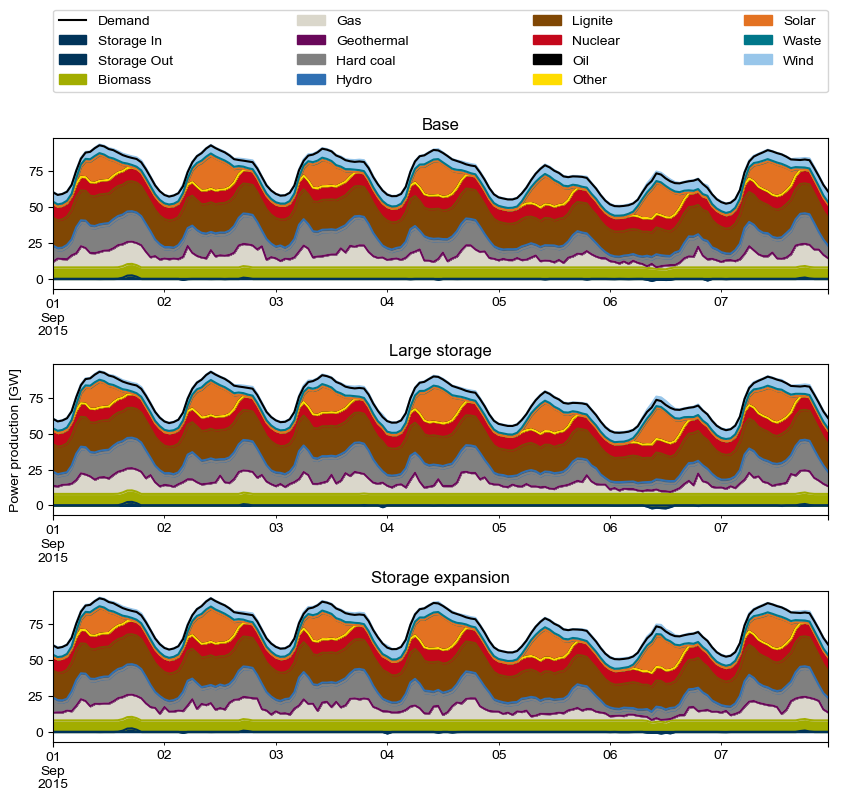

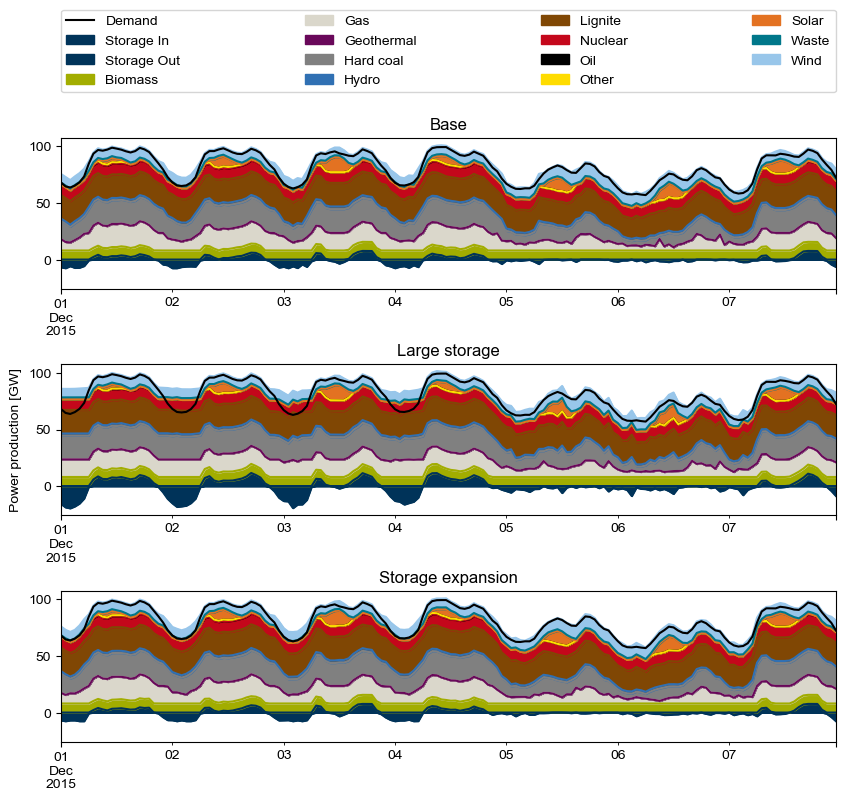

In [40]:
# dispatch per scenario
for period in plot_periods:
    fig, ax = plt.subplots(nrows = len(scenarios_mean), figsize=(10,8), dpi=100, sharey=True)

    # Set space between subplots
    fig.subplots_adjust(hspace = 0.5) 

    for scen in range(0, len(scenarios_mean)):
        e_pro = e_pro_out_mean[scenarios_mean[scen]].sum(axis=1, level=0)
        e_pro.rename(columns=define.translate_fuel,inplace=True)
        sto_out = e_sto_out_mean[scenarios_mean[scen]].sum(axis=1)
        sto_out.rename('Storage Out', inplace=True)
        sto_in = -e_sto_in_mean[scenarios_mean[scen]].sum(axis=1)
        sto_in.rename('Storage In', inplace=True)
        plot_element = pd.concat([sto_in, sto_out, e_pro], axis=1)
        plot_element = plot_element[plot_periods[period][0]:plot_periods[period][1]]
        (plot_element/1000).plot(kind='area', stacked=True, ax=ax[scen],
                                 legend=False, color=define.color_fuels.values())
        
        # plot demand
        plot_element = demand_mean[scenarios_mean[scen]][plot_periods[period][0]:plot_periods[period][1]]
        plot_element.rename('Demand', inplace=True)
        (plot_element/1000).plot(ax=ax[scen], color=tumblack)
        
        functions.axis_thousand_comma(ax[scen], ['y'])
        ax[scen].set_xlabel('')
        ax[scen].set_title(f'{define.scenario_names[scenarios_mean[scen]]}')

    ax[np.floor(len(scenarios_mean)/2).astype('int')].set_ylabel('Power production [GW]')
    functions.legend_above(ax[0])
    
    plt.savefig(os.path.join(folder_out, subfolder, f'application-e_pro_out-mean-{period}.png'),
                bbox_inches='tight', dpi=600)

### Visualization of residual load  <a id='mean-residual'></a> 
Visualization for residual load in urbs with mean wind time series
(Back to [beginning](#start))

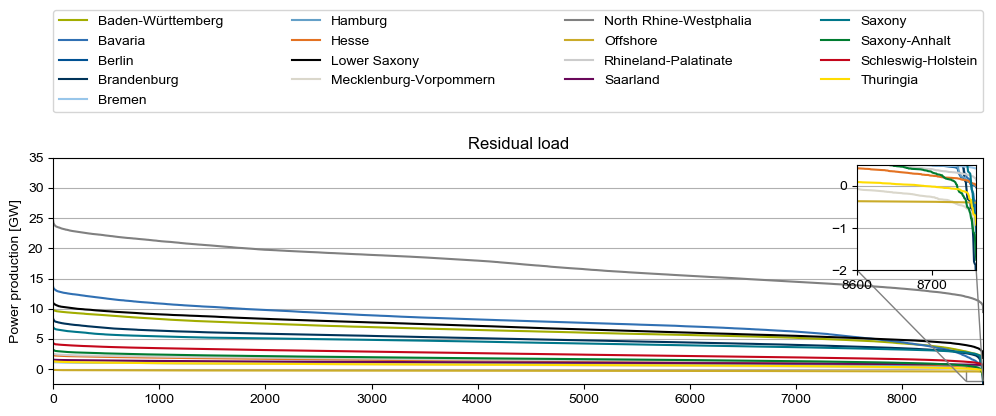

In [41]:
# residual load ordered
fig, ax = plt.subplots(nrows = 1, figsize=(12,3), dpi=100)


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
axins = zoomed_inset_axes(ax, 7, loc=1) # zoom-factor: 7, location: upper-right?

states = demand_states_mean['scenario_base'].columns.sort_values()
res = ['Solar plant', 'Wind plant']


for state in states:
    res_pro = e_pro_out_mean['scenario_base'].xs(res, axis=1).sum(axis=1, level=1).xs(state, axis=1)
    plot_element = demand_states_mean['scenario_base'][state] - res_pro
    plot_element = plot_element.sort_values(ascending=False).reset_index()[state]
    plot_element.index += 1
    (plot_element/1000).plot(ax=ax, legend=False, color=define.color_states[state])
    (plot_element/1000).plot(ax=axins, legend=False, color=define.color_states[state])

    
x1, x2, y1, y2 = 8600, 8760, -2, 0.5# specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.yaxis.grid(True)
ax.set_xlabel('')
ax.set_title('Residual load')
ax.set_ylabel('Power production [GW]')
ax.set_ylim([-2.5,35])
ax.yaxis.grid(True)
functions.legend_above(ax, anchorbox=(0., 1.2, 1., .102))
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.5")


plt.savefig(os.path.join(folder_out, subfolder, 'application-residual-load-state-mean.png'),
            bbox_inches='tight', dpi=600)

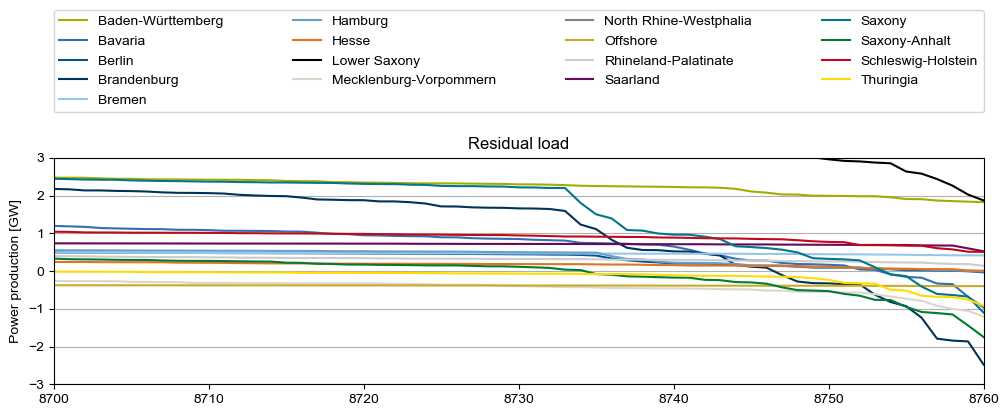

In [42]:
# zoomed in residual load for negative values

fig, ax = plt.subplots(nrows = 1, figsize=(12,3), dpi=100)

states = demand_states_mean['scenario_base'].columns.sort_values()
#['Bremen', 'Hamburg','Mecklenburg-Vorpommern', 'Brandenburg', 'Schleswig-Holstein']
res = ['Solar plant', 'Wind plant']

# Set space between subplots
#fig.subplots_adjust(hspace = 0.5) 

for state in states:
    res_pro = e_pro_out_mean['scenario_base'].xs(res, axis=1).sum(axis=1, level=1).xs(state, axis=1)
    plot_element = demand_states_mean['scenario_base'][state] - res_pro
    plot_element = plot_element.sort_values(ascending=False).reset_index()[state]
    plot_element.index += 1
    (plot_element/1000).plot(ax=ax, legend=False, color=define.color_states[state])
    (plot_element/1000).plot(ax=axins, legend=False, color=define.color_states[state])
    

ax.set_xlabel('')
ax.set_title('Residual load')
ax.set_ylabel('Power production [GW]')
ax.set_xlim([8700, 8760])
ax.set_ylim([-3.0,3.0])
ax.yaxis.grid(True)
functions.legend_above(ax, anchorbox=(0., 1.2, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder, 'application-residual-load-state-mean-end.png'),
            bbox_inches='tight', dpi=600)

## DDP urbs  <a id='ddp'></a> 
Analysis of urbs with stages for wind time series and DDP approach 
(Back to [beginning](#start))

In [43]:
folder = 'h5'
sub_folder_ddp = 'germany2015sddp-20190409T1641-one-year-ddp'
scenarios_ddp = ['scenario_ls_exp']
path_ddp = os.path.join(folder, sub_folder_ddp, h5_folder)

realizations_ddp = ['mid']

result_files = functions.glob_result_files(path_ddp)

# derive list of h5 names for naming
h5_names = [os.path.basename(rf)  # drop folder names, keep filename
                .replace(f'-iteration', '') # drop "iteration"
                .replace(f'.h5', '')  # drop file extension
                  for rf in result_files if 'scenario' in rf]

# list of names of all master and sub h5 files
h5_masters = [master for master in h5_names if 'master' in master]
h5_masters.remove('master-scenario_ls_exp')
h5_masters = sorted(h5_masters, key=lambda x: float(x.split('-')[1]))

# get maximum iteration number
max_iter_ddp = {
    item.split('-')[-1]: int(re.findall(r"\d+", item)[0])
    for item in h5_masters if len(re.findall(r"\d+", item)) > 0
}

# get all iterations
iterations_set = set(int(re.findall(r"\d+", item)[0])
    for item in h5_masters if len(re.findall(r"\d+", item)) > 0)

# dictionary of iterations per scenario
iterations_ddp = {
    scenario: sorted([iteration for iteration in iterations_set
               if iteration <= max_iter_ddp[scenario]])
               for scenario in max_iter_ddp.keys()
}

# read in result containers for master problems
rc_ddp_master = {}
for scenario in scenarios_ddp:
    for iteration in iterations_ddp[scenario]:
        help_path = [path for path in result_files
                     if all(items in path for items in [f"{scenario}", f"master",
                                                        str(iteration)])][0]
        rc_ddp_master[(scenario, iteration)] = urbs.load(help_path)

In [44]:
for scenario in scenarios_ddp:
    help_path = os.path.join(path_ddp, f'master-{scenario}.h5')
    rc_ddp_master[(scenario, 'end')] = urbs.load(help_path)

In [45]:
# storage capacity
cap_sto_c_ddp = {}
cap_sto_p_ddp = {}
help_c = {}
help_p = {}
for scenario in scenarios_ddp:
    for iteration in iterations_ddp[scenario]:
        help_c[(iteration)] = \
        rc_ddp_master[(scenario, iteration)]._result['cap_sto_c'].xs('Elec',
                                                                     level=2).xs('Pumped storage', level=1)
        help_p[iteration] = \
        rc_ddp_master[(scenario, iteration)]._result['cap_sto_p'].xs('Elec',
                                                                     level=2).xs('Pumped storage', level=1)
    cap_sto_c_ddp[scenario] = pd.DataFrame(help_c).sort_index()
    cap_sto_p_ddp[scenario] = pd.DataFrame(help_p).sort_index()

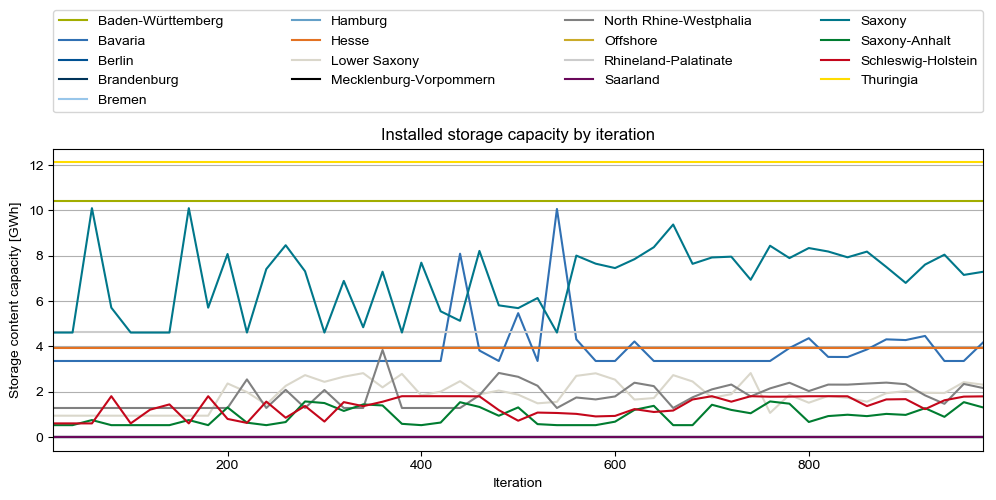

In [46]:
# plot storage capacity (c) per iteration
fig, ax = plt.subplots(nrows = 1, figsize=(12,4), dpi=100)

(cap_sto_c_ddp['scenario_ls_exp'].T/1000).plot(ax=ax,color=define.color_states.values())#, label=sit)

ax.set_title('Installed storage capacity by iteration')
ax.set_ylabel('Storage content capacity [GWh]')
ax.set_xlabel('Iteration')
ax.yaxis.grid(True)
functions.legend_above(ax, anchorbox=(0., 1.12, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder, 'application-ddp-inst-storage-capacity-all-c-iteration.png'),
            bbox_inches='tight', dpi=600)

In [47]:
# new storage capacity
cap_sto_c_new_ddp = {}
cap_sto_p_new_ddp = {}
help_c = {}
help_p = {}
for scenario in scenarios_ddp:
    for iteration in iterations_ddp[scenario] + ['end']:
        help_c[(iteration)] = \
        rc_ddp_master[(scenario, iteration)]._result['cap_sto_c_new'].xs('Elec',
                                                                     level=2).xs('Pumped storage', level=1)
        help_p[iteration] = \
        rc_ddp_master[(scenario, iteration)]._result['cap_sto_p_new'].xs('Elec',
                                                                     level=2).xs('Pumped storage', level=1)
    cap_sto_c_new_ddp[scenario] = pd.DataFrame(help_c).sort_index()
    cap_sto_p_new_ddp[scenario] = pd.DataFrame(help_p).sort_index()

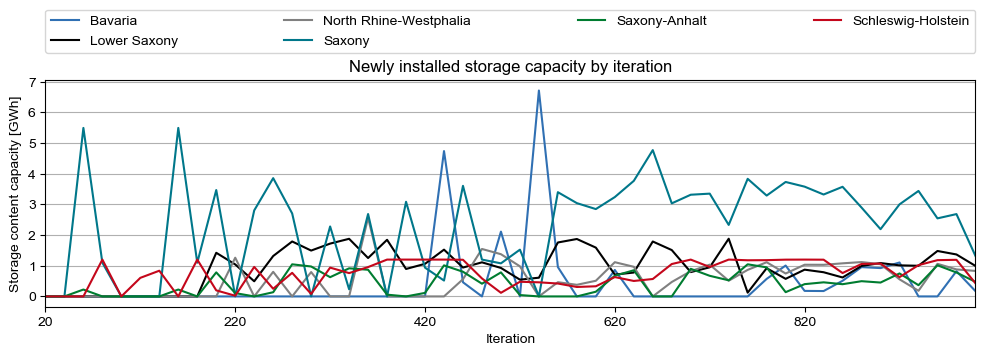

In [48]:
# plot storage capacity (c) per iteration
fig, ax = plt.subplots(nrows = 1, figsize=(12,3), dpi=100)

plot_element = cap_sto_c_new_ddp['scenario_ls_exp'][cap_sto_c_new_ddp['scenario_ls_exp'] > 0].dropna(how='all').fillna(0)
for state in plot_element.index.get_level_values('sit'):
    (plot_element.loc[state]/1000).plot(ax=ax,color=define.color_states[state])#, label=sit)

ax.set_title('Newly installed storage capacity by iteration')
ax.set_ylabel('Storage content capacity [GWh]')
ax.set_xlabel('Iteration')
ax.yaxis.grid(True)
functions.legend_above(ax, anchorbox=(0., 1.12, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder, 'application-ddp-storage-capacity-c-iteration.png'),
            bbox_inches='tight', dpi=600)

In [49]:
log_ddp = f'terminal-{scenarios_ddp[0]}.out'
path_log_ddp = os.path.join(folder, sub_folder_ddp, log_ddp)

logfile_ddp = open(path_log_ddp)

log_dict_ddp = {}

for lv, line in enumerate(logfile_ddp):
    if line != '\n':
        lhelp = line.split()
        if lhelp[0].isnumeric():
            log_dict_ddp[int(lhelp[0])] = [float(nmb) for nmb in lhelp[1:]]
            
log_df_ddp = pd.DataFrame.from_dict(log_dict_ddp, orient='index',
                                    columns=['eta', 'lb', 'ub', 'ub-mean', 'stddev', 'gap', 'obj'])

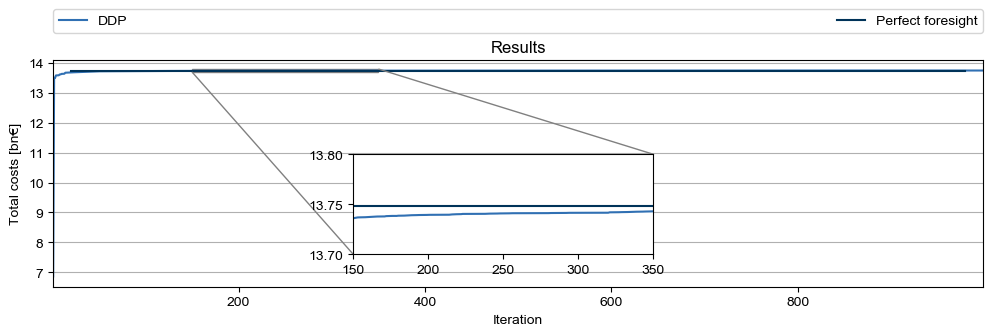

In [85]:
# plot storage capacity (c) per iteration
fig, ax = plt.subplots(nrows = 1, figsize=(12,3), dpi=100)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
axins = inset_axes(ax, 3,1, loc='center', bbox_to_anchor=(.5,.4),
                     bbox_transform=ax.figure.transFigure)

# plot upper bound and objective
(log_df_ddp[['obj']].rename({'obj': 'DDP'}, axis=1)/1000000000).plot(ax=ax, legend=False, colors=[define.tumblue])
(log_df_ddp[['obj']].rename({'obj': 'DDP'}, axis=1)/1000000000).plot(ax=axins, legend=False, colors=[define.tumblue])


original = np.empty(len(iterations_ddp['scenario_ls_exp']))
original.fill(rc_original['scenario_ls_exp']._result['costs'].sum()/1000000000)
ax.plot(iterations_ddp['scenario_ls_exp'], original, define.tumdarkblue, label='Perfect foresight')
axins.plot(iterations_ddp['scenario_ls_exp'], original, define.tumdarkblue, label='Perfect foresight')

functions.legend_above(ax, anchorbox=(0., 1.12, 1., .102), cols=5)

x1, x2, y1, y2 = 150, 350, 13.7, 13.8# specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

ax.set_xlabel('Iteration')
ax.set_title('Results')
ax.set_ylabel('Total costs [bn€]')
ax.yaxis.grid(True)
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.5")

plt.savefig(os.path.join(folder_out, subfolder, 'application-ddp-long-term-objective-bounds.png'),
           bbox_inches='tight', dpi=600)

## SDDP urbs  <a id='sddp'></a> 
Analysis of urbs with uncertain scenarios for wind time series and SDDP approach
(Back to [beginning](#start))

### Storage expansion

In [51]:
sub_folder_sddp = 'germany2015sddp-20190514T0747-one-year-sddp'#'germany2015sddp-20190425T0524-one-year-sddp'#
scenarios_sddp = ['scenario_ls_exp']
path_sddp = os.path.join(folder, sub_folder_sddp, h5_folder)

realizations_sddp = ['mid']

result_files = functions.glob_result_files(path_sddp)

# derive list of h5 names for naming
h5_names = [os.path.basename(rf)  # drop folder names, keep filename
                .replace(f'-iteration', '') # drop "iteration"
                .replace(f'.h5', '')  # drop file extension
                  for rf in result_files if 'scenario' in rf]

# list of names of all master and sub h5 files
h5_masters = [master for master in h5_names if 'master' in master]
h5_masters = sorted(h5_masters, key=lambda x: float(x.split('-')[1]))

# get maximum iteration number
max_iter_sddp = {
    item.split('-')[-1]: int(re.findall(r"\d+", item)[0])
    for item in h5_masters if len(re.findall(r"\d+", item)) > 0
}

# get all iterations
iterations_set = set(int(re.findall(r"\d+", item)[0])
    for item in h5_masters if len(re.findall(r"\d+", item)) > 0)

# dictionary of iterations per scenario
iterations_sddp = {
    scenario: sorted([iteration for iteration in iterations_set
               if iteration <= max_iter_sddp[scenario]])
               for scenario in max_iter_sddp.keys()
}

# read in result containers for master problems
rc_sddp_master = {}
for scenario in scenarios_sddp:
    for iteration in iterations_sddp[scenario]:
        help_path = [path for path in result_files
                     if all(items in path for items in [f"{scenario}", f"master",
                                                        str(iteration)])][0]
        rc_sddp_master[(scenario, iteration)] = urbs.load(help_path)

In [52]:
# storage capacity
cap_sto_c_sddp = {}
cap_sto_p_sddp = {}
help_c = {}
help_p = {}
for scenario in scenarios_sddp:
    for iteration in iterations_sddp[scenario]:
        help_c[(iteration)] = \
        rc_sddp_master[(scenario, iteration)]._result['cap_sto_c'].xs('Elec',
                                                                     level=2).xs('Pumped storage', level=1)
        help_p[iteration] = \
        rc_sddp_master[(scenario, iteration)]._result['cap_sto_p'].xs('Elec',
                                                                     level=2).xs('Pumped storage', level=1)
    cap_sto_c_sddp[scenario] = pd.DataFrame(help_c).sort_index()
    cap_sto_p_sddp[scenario] = pd.DataFrame(help_p).sort_index()

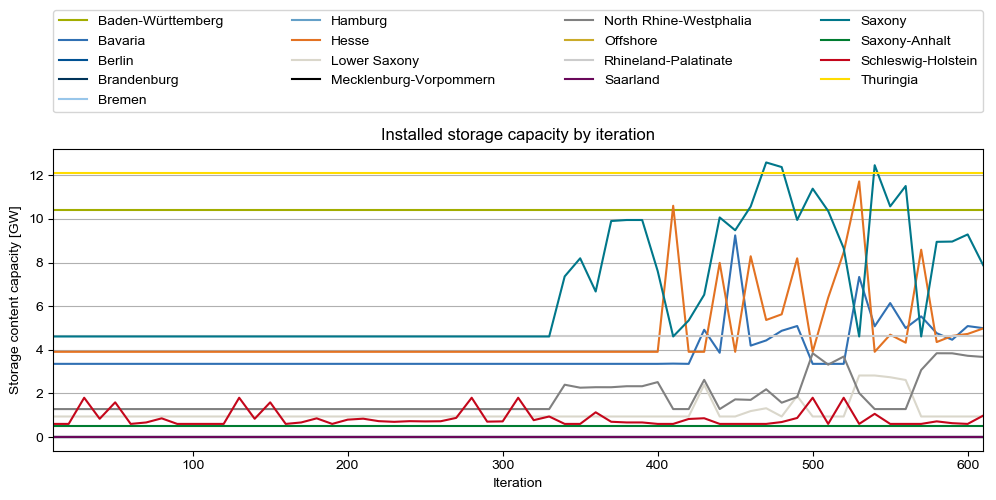

In [53]:
# plot storage capacity (c) per iteration
fig, ax = plt.subplots(nrows = 1, figsize=(12,4), dpi=100)

(cap_sto_c_sddp['scenario_ls_exp'].T/1000).plot(ax=ax,color=define.color_states.values())#, label=sit)

ax.set_title('Installed storage capacity by iteration')
ax.set_ylabel('Storage content capacity [GW]')
ax.set_xlabel('Iteration')
ax.yaxis.grid(True)
functions.legend_above(ax, anchorbox=(0., 1.12, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder, 'application-sddp-storage-capacity-all-c-iteration.png'),
            bbox_inches='tight', dpi=600)

In [54]:
# new storage capacity
cap_sto_c_new_sddp = {}
cap_sto_p_new_sddp = {}
help_c = {}
help_p = {}
for scenario in scenarios_sddp:
    for iteration in iterations_sddp[scenario]:
        help_c[(iteration)] = \
        rc_sddp_master[(scenario, iteration)]._result['cap_sto_c_new'].xs('Elec',
                                                                     level=2).xs('Pumped storage', level=1)
        help_p[iteration] = \
        rc_sddp_master[(scenario, iteration)]._result['cap_sto_p_new'].xs('Elec',
                                                                     level=2).xs('Pumped storage', level=1)
    cap_sto_c_new_sddp[scenario] = pd.DataFrame(help_c).sort_index()
    cap_sto_p_new_sddp[scenario] = pd.DataFrame(help_p).sort_index()

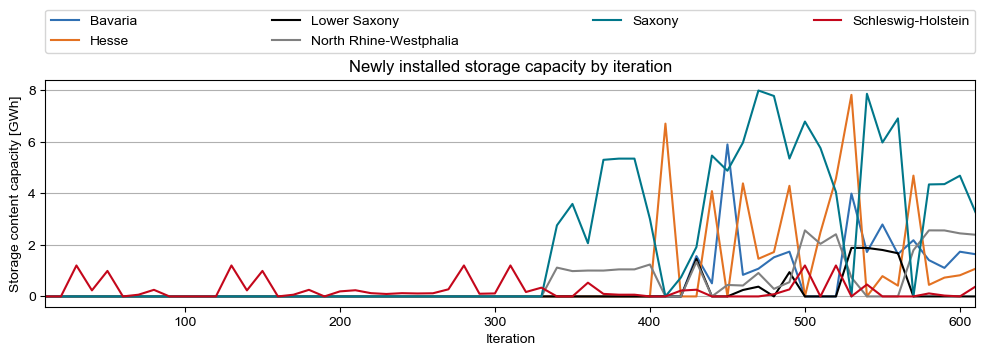

In [55]:
# plot storage capacity (c) per iteration
fig, ax = plt.subplots(nrows = 1, figsize=(12,3), dpi=100)

plot_element = cap_sto_c_new_sddp['scenario_ls_exp'][cap_sto_c_new_sddp['scenario_ls_exp'] > 0].dropna(how='all').fillna(0)
for state in plot_element.index.get_level_values('sit'):
    (plot_element.loc[state]/1000).plot(ax=ax,color=define.color_states[state])#, label=sit)

ax.set_title('Newly installed storage capacity by iteration')
ax.set_ylabel('Storage content capacity [GWh]')
ax.set_xlabel('Iteration')
ax.yaxis.grid(True)
functions.legend_above(ax, anchorbox=(0., 1.12, 1., .102))

plt.savefig(os.path.join(folder_out, subfolder, 'application-sddp-storage-capacity-c-iteration.png'),
           bbox_inches='tight', dpi=600)

In [56]:
log_sddp = f'terminal-{scenarios_sddp[0]}.out'
path_log_sddp = os.path.join(folder, sub_folder_sddp, log_sddp)

logfile_sddp = open(path_log_sddp)

log_dict_sddp = {}

for lv, line in enumerate(logfile_sddp):
    if line != '\n':
        lhelp = line.split()
        if lhelp[0].isnumeric():
            log_dict_sddp[int(lhelp[0])] = [float(nmb) for nmb in lhelp[1:]]
            
log_df_sddp = pd.DataFrame.from_dict(log_dict_sddp, orient='index',
                                    columns=['eta', 'lb', 'ub', 'ub-mean', 'stddev', 'gap', 'obj'])

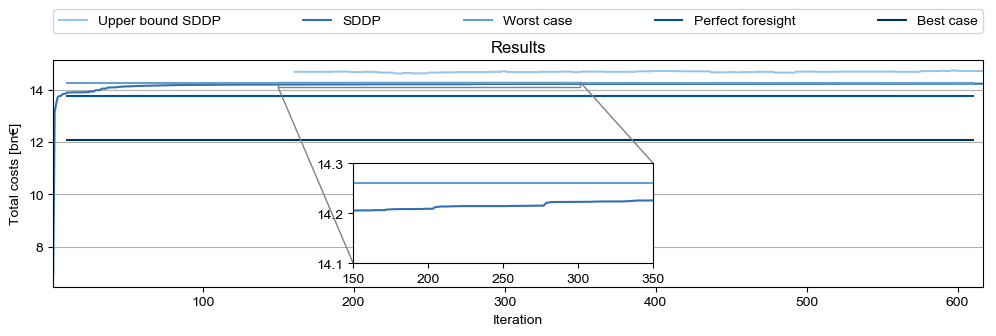

In [57]:
# plot storage capacity (c) per iteration
fig, ax = plt.subplots(nrows = 1, figsize=(12,3), dpi=100)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
axins = inset_axes(ax, 3,1, loc='center', bbox_to_anchor=(.5,.37),
                     bbox_transform=ax.figure.transFigure) # zoom-factor: 7, location: upper-right?

# plot upper bound and objective
(log_df_sddp[['ub-mean','obj']].rename({'ub-mean':'Upper bound SDDP', 'obj': 'SDDP'}, axis=1)/1000000000).plot(ax=ax, legend=False, color=[define.tumlightblue, define.tumblue])
(log_df_sddp[['ub-mean','obj']].rename({'ub-mean':'Upper bound SDDP', 'obj': 'SDDP'}, axis=1)/1000000000).plot(ax=axins, legend=False, color=[define.tumlightblue, define.tumblue])


worst_case_sddp = np.empty(len(iterations_sddp['scenario_ls_exp']))
worst_case_sddp.fill(14.2611061640547)
ax.plot(iterations_sddp['scenario_ls_exp'], worst_case_sddp, define.tumlighterblue, label='Worst case')
axins.plot(iterations_sddp['scenario_ls_exp'], worst_case_sddp, define.tumlighterblue, label='Worst case')

original = np.empty(len(iterations_sddp['scenario_ls_exp']))
original.fill(rc_original['scenario_ls_exp']._result['costs'].sum()/1000000000)
ax.plot(iterations_sddp['scenario_ls_exp'], original, define.tumdarkerblue, label='Perfect foresight')

best_case_sddp = np.empty(len(iterations_sddp['scenario_ls_exp']))
best_case_sddp.fill(12.08140850823)
ax.plot(iterations_sddp['scenario_ls_exp'], best_case_sddp, define.tumdarkblue, label='Best case')


functions.legend_above(ax, anchorbox=(0., 1.12, 1., .102), cols=5)

x1, x2, y1, y2 = 150, 350, 14.1, 14.3# specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
ax.set_xlabel('Iteration')
ax.set_title('Results')
ax.set_ylabel('Total costs [bn€]')
ax.yaxis.grid(True)
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.5")

plt.savefig(os.path.join(folder_out, subfolder, 'application-sddp-long-term-objective-bounds.png'),
           bbox_inches='tight', dpi=600)

## Comparison of storages  <a id='comp'></a> 
Compare storage capacity expansion
(Back to [beginning](#start))

In [58]:
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

# Read in shape of Germany from GADM data
sto_subfolder_shapes = 'Shapes'
sto_subfolder_vis = 'Visualization'
sto_file_shape = 'DEU_adm1.shp'
sto_path_shape = os.path.join(folder_in, sto_subfolder_vis, sto_subfolder_shapes, 
                              sto_file_shape)
sto_shape_ger = list(shpreader.Reader(sto_path_shape).geometries())

cmap = [define.tumgreen, define.tumivory, define.tumviolet, define.tumgrey, define.tumblue, define.tumbrown, 
        define.tumivory, define.tumred, define.tumblack, define.tumbrightyellow, define.tumorange, 
        define.tumturquois, define.tumlightblue]

# Define output
sto_file_out_plot = 'application-long-term-storage-comparison'
sto_path_out_plot = os.path.join(folder_out, sto_subfolder_vis, 
                                 sto_file_out_plot+dt_png)

In [59]:
scen = 'scenario_ls_exp'
capacities = {
    'Perfect foresight': cap_sto_c_new_original[scen],
    'Mean': cap_sto_c_new_mean[scen],
#    'ddp': cap_sto_c_new_ddp[scen],
    'SDDP': cap_sto_c_new_sddp[scen]
}

sto_cmap = [define.tumblue, define.tumivory, define.tumlightblue, define.tumgrey]

In [60]:
cap_sto_c_new = {}
help_df = pd.DataFrame()

for scenario in ['scenario_ls_exp']:
    for key in capacities.keys():
        try:
            help_df = pd.concat([help_df, capacities[key].iloc[:,-1].rename(key)], axis=1, sort=True)
        except:
            help_df = pd.concat([help_df, capacities[key].rename(key)], axis=1, sort=True)
    cap_sto_c_new[scenario] = help_df 

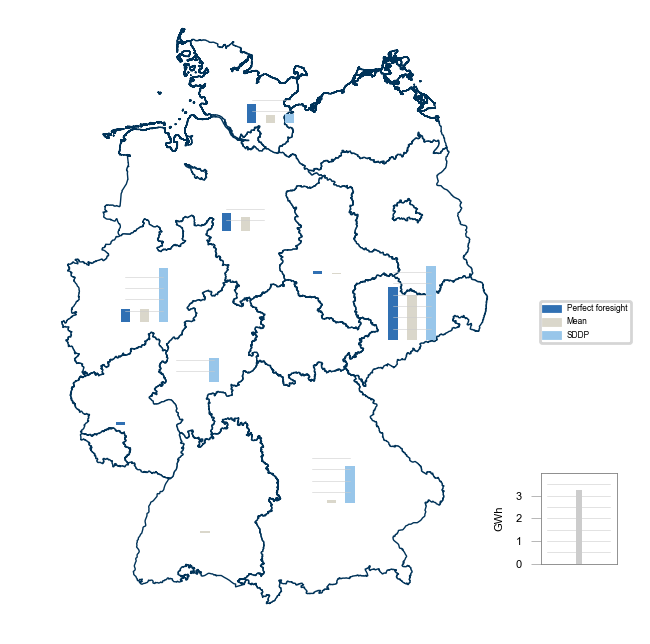

In [61]:
# Create dataframe for plotting
vis_plants = cap_sto_c_new['scenario_ls_exp'][cap_sto_c_new['scenario_ls_exp'] > 0].dropna(how='all').fillna(0)

# Create figure for capacities plot
sto_fig_raw = plt.figure(dpi=200)

# Generate shape of Germany with states
ax = plt.axes(projection=ccrs.EuroPP(), frameon=False)
ax.add_geometries(sto_shape_ger, ccrs.PlateCarree(),
              edgecolor=define.tumdarkblue, facecolor=define.tumwhite, linewidth=.5)
ax.set_extent([5.5, 15.5, 47, 55], ccrs.PlateCarree())

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

# plot per state
for state in vis_plants.index:
    ip = InsetPosition(ax, define.cap_positions_en[state])
    axin = inset_axes(ax,width=1,height=1)
    axin.set_axes_locator(ip)
    ix_height = list(vis_plants.loc[state])
    
    axin.bar(np.arange(len(vis_plants.columns)),height=ix_height, tick_label='', width=0.5,
             color=sto_cmap)
    axin.set_ylim([0,4000])
    axin.set_xlim([-1,len(vis_plants.columns)])
    axin.axis('off')
    for rvv in np.arange(0,round(max(ix_height)/1000)+0.5, 0.5):
        axin.plot(np.arange(len(vis_plants.columns)),
                  np.full(shape=len(vis_plants.columns),fill_value=rvv*1000),
                  color=define.tumlightgrey, linewidth=.2)
        #axin.background_patch.set_visible(False)

# create exemplary bar for height
ip = InsetPosition(ax, [1.01, 0.1, 0.15, 0.15])
axin = inset_axes(ax,width=1,height=1)
axin.set_axes_locator(ip)
ix_height = vis_plants.max().max()

axin.bar(np.arange(3),height=[0,ix_height/100,0], tick_label='',width=0.2, color=define.tumlightgrey)
axin.set_ylim([0,40])
axin.set_ylabel('GWh', fontsize=4)
axin.set_yticks(np.arange(0,40,10))
axin.set_yticklabels(np.arange(0,4,1), fontsize=4)
axin.yaxis.set_tick_params(width=.2, color=define.tumgrey)
for rvv in np.arange(0.5,int(ix_height/100)+1, 0.5):
    axin.plot(np.arange(3), np.full(shape=3, fill_value=rvv*10), color=define.tumlightgrey, linewidth=.2)
    
plt.setp(axin.spines.values(), linewidth=.3, color=define.tumgrey)
axin.xaxis.set_ticks_position('none')

# legend
sto_entries = vis_plants.columns
sto_patches = []
for nentry in range(0,len(sto_entries)):
    sto_patches.append(mpatches.Patch(color=sto_cmap[nentry], label=list(capacities.keys())[nentry]))

ax.legend(handles=sto_patches, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=3)

# Save plot to file
plt.gcf().savefig(sto_path_out_plot, bbox_inches='tight', dpi=1000)

### Scenario long term dispatch

In [62]:
sub_folder_sddp_dis = 'germany2015sddp-20190725T0725'#'germany2015sddp-20190425T0524-one-year-sddp'#
scenarios_sddp_dis = ['scenario_ls_dis']
path_sddp_dis = os.path.join(folder, sub_folder_sddp_dis, h5_folder)

realizations_sddp_dis = ['mid']

result_files = functions.glob_result_files(path_sddp_dis)

# derive list of h5 names for naming
h5_names = [os.path.basename(rf)  # drop folder names, keep filename
                #.replace(f'-iteration', '') # drop "iteration"
                .replace(f'.h5', '')  # drop file extension
                  for rf in result_files if 'scenario' in rf]

# list of names of all master and sub h5 files
h5_masters = [master for master in h5_names if ('master' in master and 'iteration' in master)]
h5_masters = sorted(h5_masters, key=lambda x: float(x.split('-')[2]))

# get maximum iteration number
max_iter_sddp_dis= {
    item.split('-')[-1]: int(re.findall(r"\d+", item)[0])
    for item in h5_masters if len(re.findall(r"\d+", item)) > 0
}

# get all iterations
iterations_set = set(int(re.findall(r"\d+", item)[0])
    for item in h5_masters if len(re.findall(r"\d+", item)) > 0)

# dictionary of iterations per scenario
iterations_sddp_dis = {
    scenario: sorted([iteration for iteration in iterations_set
                      for item in h5_masters
               if (iteration <= max_iter_sddp_dis[scenario]
                  and str(iteration) in item
                  and scenario in item)])
               for scenario in max_iter_sddp_dis.keys()
}

# read in result containers for master problems
rc_master_sddp_dis= {}
for scenario in scenarios_sddp_dis:
    for iteration in iterations_sddp_dis[scenario]:
        help_path = [path for path in result_files
                     if all(items in path for items in [f"{scenario}", f"master",
                                                        str(iteration)])][0]
        rc_master_sddp_dis[(scenario, iteration)] = urbs.load(help_path)
    help_path = [path for path in result_files
                     if all(items in path for items in [f"{scenario}", f"master"])
                     and 'iteration' not in path][0]
    rc_master_sddp_dis[(scenario, 'end')] = urbs.load(help_path)

In [63]:
h5_subs = [sub for sub in h5_names if 'sub' in sub]
subs_sddp_dis = set([int(re.findall(r"\d+", item)[0]) for item in h5_subs])

# read in result containers
rc_subs_sddp_dis = {}
for scenario in scenarios_sddp_dis:
    for sub in subs_sddp_dis:
        for realization in realizations_sddp_dis:
            for iteration in [50, 150, 250]:#iterations_sddp_dis[scenario]:
                help_path = [path for path in result_files
                             if all(items in path for items in [f"{scenario}",
                                                               f"sub({sub}",
                                                               realization,
                                                               str(iteration)])][0]
                rc_subs_sddp_dis[(scenario, sub, realization, iteration)] = urbs.load(help_path)
            #help_path = [path for path in result_files
            #                 if all(items in path for items in [f"{scenario}",
            #                                                   f"sub({sub}",
            #                                                   realization])
            #            and 'iteration' not in path][0]
            #rc_subs_sddp_dis[(scenario, sub, realization, 'end')] = urbs.load(help_path)

In [64]:
log_sddp_dis = f'terminal-{scenarios_sddp_dis[0]}.out'
path_log_sddp_dis = os.path.join(folder, sub_folder_sddp_dis, log_sddp_dis)

logfile_sddp_dis = open(path_log_sddp_dis)

log_dict_sddp_dis = {}

for lv, line in enumerate(logfile_sddp_dis):
    if line != '\n':
        lhelp = line.split()
        if lhelp[0].isnumeric():
            log_dict_sddp_dis[int(lhelp[0])] = [float(nmb) for nmb in lhelp[1:]]
            
log_df_sddp_dis = pd.DataFrame.from_dict(log_dict_sddp_dis, orient='index',
                                    columns=['eta', 'lb', 'ub', 'ub-mean', 'stddev', 'gap', 'obj'])

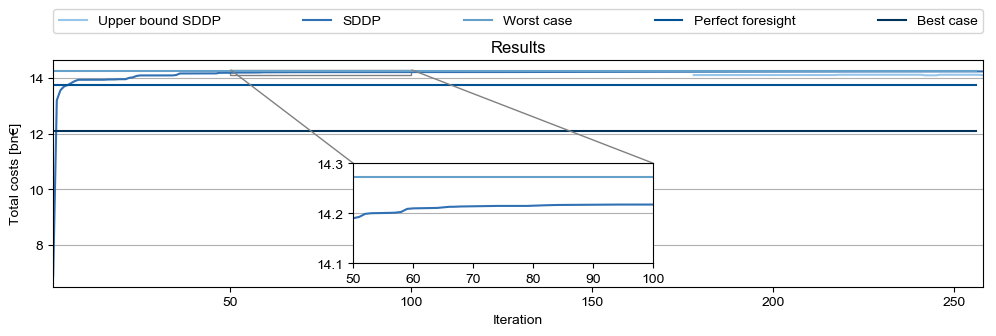

In [84]:
# plot storage capacity (c) per iteration
fig, ax = plt.subplots(nrows = 1, figsize=(12,3), dpi=100)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes,zoomed_inset_axes, mark_inset
axins = inset_axes(ax, 3,1, loc='center', bbox_to_anchor=(.5,.37),
                     bbox_transform=ax.figure.transFigure) # zoom-factor: 7, location: upper-right?

# plot upper bound and objective
(log_df_sddp_dis[['ub-mean','obj']].rename({'ub-mean':'Upper bound SDDP', 'obj': 'SDDP'}, axis=1)/1000000000).plot(ax=ax, legend=False, color=[define.tumlightblue, define.tumblue])
(log_df_sddp_dis[['ub-mean','obj']].rename({'ub-mean':'Upper bound SDDP', 'obj': 'SDDP'}, axis=1)/1000000000).plot(ax=axins, legend=False, color=[define.tumlightblue, define.tumblue])


worst_case_sddp_dis = np.empty(len(log_df_sddp_dis.index[::5]))
worst_case_sddp_dis.fill(14.27268028631)
ax.plot(log_df_sddp_dis.index[::5], worst_case_sddp_dis, define.tumlighterblue, label='Worst case')
axins.plot(log_df_sddp_dis.index[::5], worst_case_sddp_dis, define.tumlighterblue, label='Worst case')

original = np.empty(len(log_df_sddp_dis.index[::5]))
original.fill(rc_original['scenario_ls_dis']._result['costs'].sum())
ax.plot(log_df_sddp_dis.index[::5], original/1000000000, define.tumdarkerblue, label='Perfect foresight')

best_case_sddp_dis = np.empty(len(log_df_sddp_dis.index[::5]))
best_case_sddp_dis.fill(12.08123995508)
ax.plot(log_df_sddp_dis.index[::5], best_case_sddp_dis, define.tumdarkblue, label='Best case')


functions.legend_above(ax, anchorbox=(0., 1.12, 1., .102), cols=5)

x1, x2, y1, y2 = 50, 100, 14.1, 14.3# specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.yaxis.grid(True)
ax.set_xlabel('Iteration')
ax.set_title('Results')
ax.set_ylabel('Total costs [bn€]')
ax.yaxis.grid(True)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

plt.savefig(os.path.join(folder_out, subfolder, 'application-sddp-long-term-dispatch-objective-bounds.png'),
           bbox_inches='tight', dpi=600)

## Comparison of dispatch  <a id='dispatch'></a> 
Compare dispatch between approaches
(Back to [beginning](#start))

In [66]:
folder = 'h5'
sub_folder_bestworst = 'germany2015-20190710T1753-oneyear_bestword-optimal-sto'
scenarios_bestworst = ['scenario_wind_low_dis', 'scenario_wind_high_dis']
path_bestworst = os.path.join(folder, sub_folder_bestworst)
   
# extract result dictionary from result container
rc_bestworst = {}
for scenario in scenarios_bestworst:
    scenario_path = os.path.join(path_bestworst, f"{scenario}{dt_h5}")
    rc_bestworst[scenario] = urbs.load(scenario_path)

In [67]:
# process and storage
e_pro_out_bestworst = {}
e_sto_in_bestworst = {}
e_sto_out_bestworst = {}    

# CO2
e_co2_out_bestworst = {}

for scenario in scenarios_bestworst:
    # process
    help_df = rc_bestworst[scenario]._result['e_pro_out'].xs('Elec', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_pro_out_bestworst[scenario] = functions.set_date_index(help_df, datetime_origin)
    
    # storage in
    help_df = rc_bestworst[scenario]._result['e_sto_in'].xs('Elec',
                                                       level='com').xs('Pumped storage',
                                                                       level='sto').unstack()
    e_sto_in_bestworst[scenario] = functions.set_date_index(help_df, datetime_origin)

    # storage out
    help_df = rc_bestworst[scenario]._result['e_sto_out'].xs('Elec',
                                                        level='com').xs('Pumped storage',
                                                                        level='sto').unstack()
    e_sto_out_bestworst[scenario] = functions.set_date_index(help_df, datetime_origin)

    # process
    help_df = rc_bestworst[scenario]._result['e_pro_out'].xs('CO2', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_co2_out_bestworst[scenario] = functions.set_date_index(help_df, datetime_origin)

### Import of sddp dispatch sums

In [68]:
# process and storage
# perfect foresight
e_pro_out_original = {}
e_sto_in_original = {}
e_sto_out_original = {}
e_pro_co2_original = {}

for scenario in ['scenario_ls_dis']:
    # process
    help_df = rc_original[scenario]._result['e_pro_out'].xs('Elec', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_pro_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)
    
    # storage in
    help_df = rc_original[scenario]._result['e_sto_in'].xs('Elec',
                                                       level='com').xs('Pumped storage',
                                                                       level='sto').unstack()
    e_sto_in_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    # storage out
    help_df = rc_original[scenario]._result['e_sto_out'].xs('Elec',
                                                        level='com').xs('Pumped storage',
                                                                        level='sto').unstack()
    e_sto_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)
    
    # CO2
    help_df = rc_original[scenario]._result['e_pro_out'].xs('CO2', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_pro_co2_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    
# sddp
e_pro_out_sddp_dis = {}
e_sto_out_sddp_dis = {}
e_sto_in_sddp_dis = {}
e_pro_co2_sddp_dis = {}
for scenario in ['scenario_ls_dis']:
    for realization in ['mid']:
        for iteration in [50, 150, 250]:
            # process
            help_df = functions.concatination('e_pro_out', rc_subs_sddp_dis,
                                              scenario, realization, iteration,
                                              subs_sddp_dis)
            help_df = functions.summarize_plants(help_df)
            e_pro_out_sddp_dis[(scenario, realization, iteration)] = functions.set_date_index(help_df,
                                                                                          datetime_origin)
            
            # storage out
            help_df = functions.concatination('e_sto_out', rc_subs_sddp_dis,
                                    scenario, realization, iteration, subs_sddp_dis)
            e_sto_out_sddp_dis[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
            # storage in
            help_df = functions.concatination('e_sto_in', rc_subs_sddp_dis,
                                    scenario, realization, iteration, subs_sddp_dis)
            e_sto_in_sddp_dis[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
            # CO2
            help_df = functions.concatination('e_pro_out', rc_subs_sddp_dis,
                                    scenario, realization, iteration, subs_sddp_dis, com='CO2')
            help_df = functions.summarize_plants(help_df)
            e_pro_co2_sddp_dis[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        
        # last iteration
        
        # process
        #help_df = functions.concatination('e_pro_out', rc_subs_sddp_dis, scenario, realization, 'end',
        #                        subs_sddp_dis, rc_master=rc_master_sddp_dis)
        #help_df = functions.summarize_plants(help_df)
        #e_pro_out_sddp_dis[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)
        
        # storage out
        #help_df = functions.concatination('e_sto_out', rc_subs_sddp_dis, scenario, realization, 'end', subs_sddp_dis)
        #e_sto_out_sddp_dis[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)
        
        # storage in
        #help_df = functions.concatination('e_sto_in', rc_subs_sddp_dis, scenario, realization, 'end', subs_sddp_dis)
        #e_sto_in_sddp_dis[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)
        
        # CO2
        # help_df = functions.concatination('e_pro_out', rc_subs_sddp_dis, scenario, realization,
        #                        'end', subs_sddp_dis, com='CO2')
        # help_df = functions.summarize_plants(help_df)
        # e_pro_co2_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

In [69]:
# Importing color codes
cmap = [define.tumgreen, define.tumivory, define.tumviolet,
        define.tumgrey, define.tumblue, define.tumbrown, define.tumred,
        define.tumblack, define.tumbrightyellow, define.tumorange, 
        define.tumturquois, define.tumlightblue]

cmap_de = [define.tumbrown, define.tumgrey, define.tumred, define.tumivory, define.tumblack, define.tumturquois,
           define.tumgreen, define.tumlightblue, define.tumorange, define.tumblue,
           define.tumviolet, define.tumbrightyellow, define.tumgrey]

tumdarkblue = define.tumdarkblue
tumblue = define.tumblue
tumwhite = define.tumwhite

# Importing dict to translate state names to English
translation = define.states_translation_de_en

# Importing dict to translate fuel names
translation_fuel = define.fuel_translation_de_en

In [70]:
help_elec_ger = {}
help_co2_ger = {}

# prepare validation dataframe
for scenario in scenarios_bestworst:
    help_elec_ger[scenario]=e_pro_out_bestworst[scenario].stack().sum(axis=0, level=1).sum()
    help_co2_ger[scenario]= e_co2_out_bestworst[scenario].stack().sum(axis=0, level=1).sum()

    
for scenario in ['scenario_ls_dis']:
    help_elec_ger['sddp'] = e_pro_out_sddp_dis[(scenario, 'mid', 250)].stack().sum()
    help_elec_ger['sddp-150'] = e_pro_out_sddp_dis[(scenario, 'mid', 150)].stack().sum()
    help_elec_ger['sddp-50'] = e_pro_out_sddp_dis[(scenario, 'mid', 50)].stack().sum()
    help_elec_ger['original'] = e_pro_out_original[scenario].stack().sum(axis=0, level=1).sum()
    
    help_co2_ger['sddp'] = e_pro_co2_sddp_dis[(scenario, 'mid', 250)].stack().sum()
    help_co2_ger['sddp-150'] = e_pro_co2_sddp_dis[(scenario, 'mid', 150)].stack().sum()
    help_co2_ger['sddp-50'] = e_pro_co2_sddp_dis[(scenario, 'mid', 50)].stack().sum()
    help_co2_ger['original'] = e_pro_co2_original[scenario].stack().sum(axis=0, level=1).sum()


In [71]:
# Add data for elec
urbs_elec_val = pd.concat([help_elec_ger['scenario_wind_low_dis']/1000000,
                           help_elec_ger['sddp']/1000000,
                           help_elec_ger['original']/1000000,
                           help_elec_ger['scenario_wind_high_dis']/1000000], axis=1)
urbs_elec_val.rename(columns={0: 'Low wind', 1:'SDDP', 2: 'Perfect Foresight', 3: 'High wind'}, inplace=True)

#Add data for co2
urbs_co2_val = pd.concat([help_co2_ger['scenario_wind_low_dis']/1000000,
                          help_co2_ger['sddp']/1000000,
                          help_co2_ger['original']/1000000,
                          help_co2_ger['scenario_wind_high_dis']/1000000], axis=1)
urbs_co2_val.fillna(0, inplace=True)
urbs_co2_val.columns = ['Low wind', 'SDDP', 'Perfect Foresight', 'High wind']

# Adapt dataframes to comparison files
urbs_elec_val.sort_index(inplace=True)
urbs_co2_val.sort_index(inplace=True)

# order
rows = ['Lignite', 'Hard coal', 'Nuclear', 'Gas',   
        'Oil', 'Other', 'Biomass', 'Wind', 'Solar', 'Hydro', 'Geothermal', 'Waste']

urbs_elec_val.rename(index=define.translate_fuel,inplace=True)
urbs_elec_val = urbs_elec_val.loc[rows, :]
urbs_co2_val.rename(index=define.translate_fuel,inplace=True)
urbs_co2_val = urbs_co2_val.loc[rows, :]

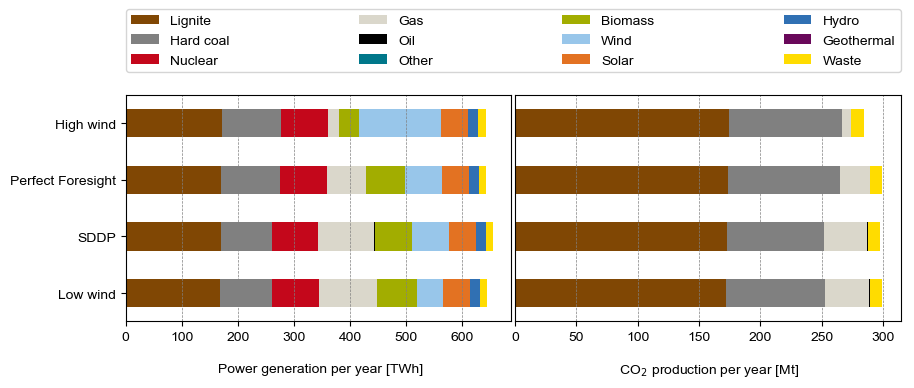

In [72]:
# Set hatch color
plt.rcParams['hatch.color'] = 'black'

# Plot validation in one figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3), dpi=100)
fig.subplots_adjust(wspace = 0.01) # set space between subplots

# Plot elec
ax1 = urbs_elec_val.T.plot(kind='barh', stacked=True, legend=False, rot=0, color=cmap_de,
                           ax=axes[0])

# Add legend
#ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))#, prop={'size': })
ax1.set_xlabel('\n Power generation per year [TWh]')
ax1.xaxis.grid(color='grey', linestyle='--', linewidth=.5)

# Plot co2
ax2 = urbs_co2_val.T.plot(kind='barh', stacked=True, legend=False, rot=0, color=cmap_de,
                          ax=axes[1])

# Add legend
ax2.set_xlabel('\n CO$_2$ production per year [Mt]')
ax2.axes.get_yaxis().set_visible(False)
ax2.grid(color='grey', linestyle='--', linewidth=.5)

functions.legend_above(axes[0], anchorbox=(0., 1.1, 2.01, .102))

# Define output and save file
val_file_out = 'application-cs-comparison-worst-sddp-pf-best'
val_path_out = os.path.join(folder_out, subfolder, val_file_out+dt_png)
plt.gcf().savefig(val_path_out, bbox_inches='tight', dpi=600)

## Comparison of costs  <a id='costs'></a> 
Compare costs between approaches
(Back to [beginning](#start))

In [73]:
costs_original = {}
costs_mean = {}


for scenario in scenarios_original:
    costs_original[scenario] = rc_original[scenario]._result['costs']
    costs_mean[scenario] = rc_mean[scenario]._result['costs']
    
costs_original_df = pd.DataFrame(costs_original)
costs_mean_df = pd.DataFrame(costs_mean)

In [74]:
costs_ddp = {}
costs_sddp = {}


for scenario in scenarios_ddp:
    costs_ddp[scenario] = rc_ddp_master[(scenario,iterations_ddp[scenario][-1])]._result['costs']
    costs_sddp[scenario] = rc_sddp_master[(scenario,iterations_sddp[scenario][-1])]._result['costs']
    
costs_ddp_df = pd.DataFrame(costs_ddp)
costs_sddp_df = pd.DataFrame(costs_sddp)

In [75]:
costs = {}

for scenario in scenarios_original:
    costs[scenario] = pd.concat([
        costs_original_df[scenario].rename('Perfect foresight'),
        costs_mean_df[scenario].rename('Mean')
    ], axis=1, sort=True)
    
    if scenario in scenarios_ddp:
        costs[scenario] = pd.concat([
            costs[scenario],
            costs_ddp[scenario].rename('DDP'),
            costs_sddp[scenario].rename('SDDP')
        ], axis=1, sort=True)

In [76]:
costs['scenario_ls_exp']['Perfect foresight'].sum() - costs['scenario_ls_exp']['Perfect foresight']['Invest']

13746476162.489996

In [77]:
costs['scenario_ls_exp']

Perfect foresight          Mean           DDP          SDDP
Environmental       0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
Fixed               6.861378e+09  6.861378e+09  6.861378e+09  6.861378e+09
Fuel                1.070547e+10  1.085064e+10  0.000000e+00  0.000000e+00
FutureCosts                  NaN           NaN  6.884080e+09  7.369317e+09
Invest              2.194163e+06  1.769527e+06  3.545836e+06  4.015206e+06
Purchase            0.000000e+00  0.000000e+00           NaN           NaN
Revenue             0.000000e+00  0.000000e+00           NaN           NaN
Variable           -3.820377e+09 -3.893620e+09  0.000000e+00  0.000000e+00

In [78]:
for scenario in scenarios_original:
    print(scenario)
    print(costs[scenario].sum())
    print(costs[scenario].sum()['Perfect foresight'] - costs[scenario].sum()['Mean'])

scenario_base
Perfect foresight    1.374977e+10
Mean                 1.382109e+10
dtype: float64
-71322014.95999908
scenario_ls
Perfect foresight    1.389211e+10
Mean                 1.396409e+10
dtype: float64
-71978451.23999977
scenario_ls_exp
Perfect foresight    1.374867e+10
Mean                 1.382017e+10
DDP                  1.374900e+10
SDDP                 1.423471e+10
dtype: float64
-71497775.06325912


In [79]:
evpi = costs['scenario_ls_exp'].sum()['Perfect foresight'] - costs['scenario_ls_exp'].sum()['SDDP']
evpi/costs['scenario_ls_exp'].sum()['Perfect foresight']

-0.03535177656400453

In [80]:
vss = costs['scenario_ls_exp'].sum()['Mean'] - costs['scenario_ls_exp'].sum()['SDDP']
vss/costs['scenario_ls_exp'].sum()['Mean']

-0.02999544892063451

In [81]:
costs['scenario_ls_exp'].sum()['SDDP']

14234710246.715881